#


# Sales Predictions using Machine Learning
Notebook by: Omer Hausner
---
---

# Data Overview:

Here is the plain text summary ready to be copied into a Markdown cell in your notebook:

# 📊 Dataset Overview: Store Sales Forecasting

This dataset contains historic data from **Corporación Favorita**, a large Ecuador-based grocery retailer. The goal is to predict sales for various product families across different stores.

Link to data - [kaggle link](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

---

### 🗂️ Core Files

* **train.csv**: The training data, comprising time series of features `store_nbr`, `family`, and `onpromotion` as well as the target `sales`.
* **sales**: Total sales for a product family. Fractional values are possible (e.g., 1.5 kg of cheese).
* **onpromotion**: Total number of items in a product family being promoted at a store on a given date.


* **test.csv**: The test data. The dates are for the **15 days** after the last date in the training data.
* **stores.csv**: Store metadata, including `city`, `state`, `type`, and `cluster` (a grouping of similar stores).
* **oil.csv**: Daily oil price. Ecuador is an oil-dependent country; its economical health is highly vulnerable to shocks in oil prices.
* **holidays_events.csv**: Holidays and Events metadata.

---

### 🔍 Key Domain Knowledge & Logic

#### 1. Holiday Handling

Special attention must be paid to the **transferred** column:

* **Transferred Holiday**: A holiday that falls on the calendar but was moved by the government. It behaves like a **normal day**.
* **Transfer Type**: Look for rows where type is 'Transfer' to find the day the holiday was actually celebrated.
* **Bridge**: Extra days added to extend a break (long weekends).
* **Work Day**: Days (like Saturdays) meant to "pay back" Bridge days; they behave like regular work days.

#### 2. Socio-Economic Factors

* **Public Sector Wages**: Paid every two weeks on the **15th** and the **last day of the month**. This frequently causes spikes in supermarket sales.
* **Earthquake Impact**: A magnitude 7.8 earthquake struck Ecuador on **April 16, 2016**. Relief efforts and donations greatly affected supermarket sales for several weeks after the event.
* **Oil Dependency**: As an oil-dependent nation, daily fluctuations in oil prices are a leading indicator of consumer spending power.

---

### 📈 Technical Approach

* **Feature Engineering**: Incorporate rolling averages, lags, and slopes to capture momentum.
* **Recursive Forecasting**: Since the test set spans 15 days and relies on lagged features, predictions must be made day-by-day, feeding each day's prediction back into the model as an input for the next day.
* **Scaling**: Numerical features should be Z-score scaled (StandardScaler) to ensure models like Ridge Regression treat all features fairly.

# Imports

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Ridge, LinearRegression
from xgboost import XGBRegressor

from tqdm import tqdm

tqdm.pandas()


# Utils

In [2]:
def specific_df(df, store, family):
    return df[(df['store_nbr'] == store) & (df['family'] == family)]

In [3]:
# 1. Barplot Function
def plot_categorical_bar(df, category_col, target_col='sales', agg_type='mean', top_k=None, tilt_angle=0):
    """
    Generates a bar plot with value labels.
    - If 'mean': shows the mean with Standard Deviation error bars.
    - If 'sum': shows the total sum (no error bars).
    """
    plt.figure(figsize=(10, 6))
    
    # Define estimator and error bar settings based on user input
    if agg_type == 'mean':
        estimator_func = 'mean'
        error_bar_setting = 'sd' # Standard Deviation
        title_text = f"Mean of {target_col} by {category_col} (with Std Dev)"
    elif agg_type == 'sum':
        estimator_func = 'sum'
        error_bar_setting = None # No error bars for simple sums
        title_text = f"Sum of {target_col} by {category_col}"
    else:
        raise ValueError("agg_type must be either 'mean' or 'sum'")

    order_df = df.groupby(category_col)[target_col].agg(estimator_func).reset_index()
    order_df = order_df.sort_values(target_col, ascending=False)

    if top_k:
            order_df = order_df.head(top_k)

    sort_order = order_df[category_col].tolist()

    # Create the plot
    ax = sns.barplot(
        data=df, 
        x=category_col, 
        y=target_col, 
        estimator=estimator_func, 
        # errorbar=error_bar_setting,
        capsize=0.1, # Adds little caps to the error bars
        palette='viridis',
        order=sort_order
    )

    # Add value labels on top of bars
    for container in ax.containers:
        # We assume the first container holds the bars. 
        # Note: If error bars exist, they are distinct artists, handled automatically by bar_label in newer mpl versions
        ax.bar_label(container, fmt='%.2f', padding=3)

    plt.xticks(rotation=tilt_angle)
    plt.title(title_text)
    plt.ylabel(f"{target_col} ({agg_type})")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# 2. Statistical Test Function
def run_stat_test(df, category_col, target_col='sales'):
    """
    Analyzes the relationship between a categorical and numeric variable.
    - 2 Categories: Independent T-Test
    - >2 Categories: One-way ANOVA
    """
    # Drop NaNs for the calculation
    clean_df = df[[category_col, target_col]].dropna()
    
    # Get unique categories
    groups = clean_df[category_col].unique()
    
    # Create a list of arrays (one for each category)
    group_data = [clean_df[clean_df[category_col] == g][target_col] for g in groups]
    
    print(f"--- Statistical Test: {target_col} by {category_col} ---")
    
    if len(groups) == 2:
        print(f"Detected 2 groups: {groups}. Running T-Test.")
        stat, p_val = stats.ttest_ind(group_data[0], group_data[1])
        test_name = "T-Test"
    elif len(groups) > 2:
        print(f"Detected {len(groups)} groups. Running One-way ANOVA.")
        stat, p_val = stats.f_oneway(*group_data)
        test_name = "ANOVA"
    else:
        print("Error: Need at least 2 categories to perform a statistical test.")
        return None

    # Output results
    print(f"{test_name} Statistic: {stat:.4f}")
    print(f"P-Value: {p_val:.4e}")
    
    if p_val < 0.05:
        print("Result: Significant difference (p < 0.05)")
    else:
        print("Result: No significant difference (p >= 0.05)")
        
    return stat, p_val

# 3. Scatter Plot Function
def plot_scatter(df, x_col, y_col, heat_col=None):
    plt.figure(figsize=(10, 6))

    plt.scatter(df[x_col], df[y_col], c=df[heat_col] if heat_col else None, cmap='viridis')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    # Move legend outside if crowded
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [4]:
# 4. Timeline Plot Function
def plot_timeline(df, time_col, target_col, category_col=None, rolling_window=0):
    """
    Plots a target variable over time.
    - If category_col is provided: plots multiple lines (one per category).
    - Automatically sorts by time_col to prevent "zigzag" lines.
    """
    plt.figure(figsize=(12, 6))
    
    # Sort data by time to ensure the line flows correctly from left to right
    df_sorted = df.sort_values(by=time_col)
    
    if rolling_window > 0:
        df_sorted[target_col] = df_sorted[target_col].rolling(rolling_window).mean()

    sns.lineplot(
        data=df_sorted,
        x=time_col,
        y=target_col,
        hue=category_col,       # Optional category split
        # marker='o',             # Adds dots to data points for visibility
        palette='tab10' if category_col else None
    )
    
    title = f"Timeline: {target_col} over {time_col}"
    if category_col:
        title += f" (grouped by {category_col})"
        
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# 5. Time-Series Decomposition Function
def plot_ts_decomposition(df, time_col, target_col, period=7, model='additive'):
    """
    Decomposes a time series into Trend, Seasonality, and Residuals.
    
    Parameters:
    - period: The frequency of the data (e.g., 12 for monthly, 7 for daily, 4 for quarterly).
    - model: 'additive' or 'multiplicative'. 
      Use 'additive' if the magnitude of seasonality is constant.
      Use 'multiplicative' if seasonality increases as the trend increases.
    """
    # Prepare data: Set time as index and sort
    # We create a copy to avoid modifying the original dataframe outside the function
    ts_data = df.copy()
    
    # Ensure time_col is datetime objects (optional but recommended for real dates)
    # If your input is just numbers (1, 2, 3...), this step is skipped automatically.
    if pd.api.types.is_string_dtype(ts_data[time_col]):
         ts_data[time_col] = pd.to_datetime(ts_data[time_col])
         
    ts_data = ts_data.set_index(time_col).sort_index()
    
    # Check for missing values which break decomposition
    if ts_data[target_col].isnull().any():
        print("Warning: Missing values detected. Interpolating linearly.")
        ts_data[target_col] = ts_data[target_col].interpolate(method='linear')

    # Perform Decomposition
    print(f"Running decomposition (Period={period}, Model={model})...")
    decomposition = seasonal_decompose(ts_data[target_col], model=model, period=period)
    
    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    decomposition.observed.plot(ax=ax1, title='Observed (Original Data)', color='black')
    decomposition.trend.plot(ax=ax2, title='Trend', color='blue')
    decomposition.seasonal.plot(ax=ax3, title='Seasonality', color='green')
    decomposition.resid.plot(ax=ax4, title='Residuals (Noise)', color='red', marker='o', linestyle='None')
    
    plt.tight_layout()
    plt.show()

def aggregate_for_time_series(df, time_col, target_col, method='mean'):
    """
    Groups data by time_col and aggregates the target_col.
    method: 'mean' (for averages) or 'sum' (for totals like total revenue).
    """
    if method == 'mean':
        # Useful for things like 'Average Price' or 'Temperature'
        df_agg = df.groupby(time_col)[target_col].mean().reset_index()
    elif method == 'sum':
        # Useful for 'Total Sales' or 'Total Clicks'
        df_agg = df.groupby(time_col)[target_col].sum().reset_index()
    
    return df_agg



In [5]:
def fill_missing_dates(df, date_col, category_cols, target_col='sales', fill_value=0):
    """
    Ensures the dataframe has a continuous timeline for every group.
    - category_cols: List of columns defining the groups (e.g. ['Store', 'Category'])
    """
    # 1. Convert to datetime if needed
    df[date_col] = pd.to_datetime(df[date_col])
    
    # 2. Get the full range of dates (Min date to Max date)
    # This automatically includes Dec 12th and any other gaps
    full_dates = pd.date_range(start=df[date_col].min(), 
                               end=df[date_col].max(), 
                               freq='D')
    
    print(f"Filling missing dates from {full_dates.min().date()} to {full_dates.max().date()}")
    
    # 3. Get unique values for your groups (Store, Category, etc.)
    unique_groups = [df[c].unique() for c in category_cols]
    
    # 4. Create the "Master Index" (Cartesian Product)
    # This creates every possible combination of Date + Store + Category
    # structure: [Dates] x [Stores] x [Categories]
    iterables = [full_dates] + unique_groups
    multi_index = pd.MultiIndex.from_product(iterables, names=[date_col] + category_cols)
    
    dates_missing = full_dates.difference(df[date_col].unique())
    print(f"Missing dates to be filled: {dates_missing.date.tolist()}")
    # 5. Reindex the dataframe
    # We set the index to match our Master Index, then reindex.
    # 'fill_value=0' puts a 0 where data was missing (e.g., Dec 12)
    df_filled = df.set_index([date_col] + category_cols)\
                  .reindex(multi_index)\
                  .reset_index()
    df_filled[target_col] = df_filled[target_col].fillna(fill_value)
    
    return df_filled


In [ ]:
def prepare_and_fit_train(model, train_df, categorical_features=[], numerical_features=[], target_col='sales', feature_selection=False):

    """!!! train_df should include all engineered features"""

    X_train = train_df[categorical_features + numerical_features]
    y_train = train_df[target_col]

    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train.fillna(0, inplace=True)

    cols_to_min_max = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter']
    cols_not_scale = ['month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'quarter_sin', 'quarter_cos']
    cols_to_z_normalize = [col for col in numerical_features if col not in (cols_not_scale+cols_to_min_max)]

    if feature_selection:
        categorical_features = [x for x in categorical_features if x in feature_selection]
        numerical_features = [x for x in numerical_features if x in feature_selection]
        X_train = X_train[feature_selection]
    
    minmax_scaler = MinMaxScaler()
    X_train[cols_to_min_max] = minmax_scaler.fit_transform(X_train[cols_to_min_max])

    z_scaler = StandardScaler()
    X_train[cols_to_z_normalize] = z_scaler.fit_transform(X_train[cols_to_z_normalize])


    X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)

    model.fit(X_train, y_train)

    predictions = np.clip(model.predict(X_train), 0, None) # Clip negative predictions to 0.0
    results = pd.DataFrame({'actual': y_train, 'predicted': predictions, 'date': new_train_df_w_time['date']})

    ## We know that sales on January 1st and December 25th are 0 for all stores and categories.
    januaries_1st = ["2015-01-01", "2016-01-01", "2017-01-01", "2018-01-01", "2019-01-01"]
    christmans_dates = ["2015-12-25", "2016-12-25", "2017-12-25", "2018-12-25", "2019-12-25"]
    results.loc[(results['date'].isin(januaries_1st+christmans_dates)), 'predicted'] = 0
    corrected_predictions = results['predicted']

    print(f"RMSE: {root_mean_squared_error(y_train, corrected_predictions)}")
    print(f"MAE: {mean_absolute_error(y_train, corrected_predictions)}")

    return model, minmax_scaler, z_scaler 

    

In [ ]:
def predict_test(trained_model, minmax_scaler, z_scaler, test_df, train_df, categorical_features=[], numerical_features=[], target_col='sales', feature_selection=False):
    dates_to_predict = sorted(test_df['date'].unique())
    dates_trained_on = sorted(train_df['date'].unique())
    history_dates_to_use = dates_trained_on[-60:]

    columns = test_df.columns
    history_data = new_train_df_w_time[new_train_df_w_time['date'].isin(history_dates_to_use)][columns]

    predicted_results_list = []

    for current_date in tqdm(dates_to_predict, desc='Predicting test set'):
        # print(f'Preparing data for date: {current_date.date()}')
        current_date_data = test_df[test_df['date']==current_date]
        current_date_data.drop(columns=['id'], inplace=True, errors='ignore')
        

        engineered_df = pd.concat([history_data, current_date_data], axis=0)
        engineered_df = engineer_features(engineered_df)
        engineered_test = engineered_df[engineered_df['date']==current_date]

        if feature_selection:
            categorical_features = [x for x in categorical_features if x in feature_selection]
            numerical_features = [x for x in numerical_features if x in feature_selection]
            X_test = X_test[feature_selection]

        X_test = engineered_test[categorical_features + numerical_features]
        y_test = engineered_test[target_col]

        X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_test.fillna(0, inplace=True)

        X_test[cols_to_min_max] = minmax_scaler.transform(X_test[cols_to_min_max])

        X_test[cols_to_z_normalize] = z_scaler.transform(X_test[cols_to_z_normalize])


        X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
        X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
        
        # print(f'Predicting sales for date: {current_date.date()}')
        test_predictions = np.clip(trained_model.predict(X_test), 0, None) # Clip negative predictions to 0.0
        test_results = pd.DataFrame({'actual': y_test, 'predicted': test_predictions, 'date': [current_date] * len(test_predictions)})
        test_results.loc[(test_results['date'].isin(januaries_1st+christmans_dates)), 'predicted'] = 0
        corrected_test_predictions = test_results['predicted']

        history_data = pd.concat([history_data, current_date_data], axis=0)
        predicted_results_list.extend(corrected_test_predictions.tolist())
        # print(f"num predictions is {len(predicted_results_list)}")

    print(f"RMSE: {root_mean_squared_error(test_df[target_col], predicted_results_list)}")
    print(f"MAE: {mean_absolute_error(test_df[target_col], predicted_results_list)}")

    return predicted_results_list

In [ ]:
# 1. Feature Engineering Function (Your Logic Encapsulated)
def engineer_features(df_in):
    """
    Applies the specific rolling/lag logic provided by the user.
    """
    df = df_in.copy()
    
    # --- A. Family Level Features ---
    # Note: We must maintain the index or merge carefully. 
    # The safest way in a loop is to calculate on the full temp DF and return columns.
    
    # 1. Rolling mean of sales per family
    # (We group by date+family first to get daily family totals, then calc lags)
    family_daily = df.groupby(['date', 'family'])['sales'].mean().reset_index()
    
    # Calculate the LAGS (Shift 1)
    family_daily['sales_last_day_family'] = family_daily.groupby('family')['sales'].transform(lambda x: x.shift(1))
    
    # Now calculate rolling on the LAGGED value (to avoid leakage)
    # Note: Your original logic used transform on 'sales_last_day_family', which is correct for recursion
    grouper = family_daily.groupby('family')['sales_last_day_family']
    
    family_daily['rolling_mean_family_7'] = grouper.transform(lambda x: x.rolling(7).mean())
    family_daily['rolling_mean_family_30'] = grouper.transform(lambda x: x.rolling(30).mean())
    family_daily['sales_week_ago_family'] = grouper.transform(lambda x: x.shift(7))
    family_daily['sales_month_ago_family'] = grouper.transform(lambda x: x.shift(30))
    
    # Ratios / Slopes (Handle division by zero if necessary, usually np.inf or NaN)
    family_daily['weekly_change_family'] = family_daily['sales_last_day_family'] / family_daily['sales_week_ago_family']
    family_daily['weekly_slope_family'] = (family_daily['sales_last_day_family'] - family_daily['sales_week_ago_family']) / 7
    family_daily['monthly_slope_family'] = (family_daily['sales_last_day_family'] - family_daily['sales_month_ago_family']) / 30
    
    # Merge back to main df
    df = df.merge(family_daily.drop(columns=['sales']), on=['date', 'family'], how='left')

    # --- B. Store-Family Level Features ---
    store_family_daily = df.groupby(['date', 'store_nbr', 'family'])['sales'].mean().reset_index()
    store_family_daily['sales_last_day_store_family'] = store_family_daily.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1))
    
    grouper_sf = store_family_daily.groupby(['store_nbr', 'family'])['sales_last_day_store_family']
    
    store_family_daily['rolling_mean_store_family_7'] = grouper_sf.transform(lambda x: x.rolling(7).mean())
    store_family_daily['rolling_mean_store_family_30'] = grouper_sf.transform(lambda x: x.rolling(30).mean())
    store_family_daily['sales_week_ago_store_family'] = grouper_sf.transform(lambda x: x.shift(7))
    store_family_daily['sales_month_ago_store_family'] = grouper_sf.transform(lambda x: x.shift(30))
    
    store_family_daily['weekly_change_store_family'] = store_family_daily['sales_last_day_store_family'] / store_family_daily['sales_week_ago_store_family']
    store_family_daily['weekly_slope_store_family'] = (store_family_daily['sales_last_day_store_family'] - store_family_daily['sales_week_ago_store_family']) / 7
    store_family_daily['monthly_slope_store_family'] = (store_family_daily['sales_last_day_store_family'] - store_family_daily['sales_month_ago_store_family']) / 30

    df = df.merge(store_family_daily.drop(columns=['sales']), on=['date', 'store_nbr', 'family'], how='left')

    # --- C. Store Level Features ---
    store_daily = df.groupby(['date', 'store_nbr'])['sales'].mean().reset_index()
    store_daily['sales_last_day_store'] = store_daily.groupby('store_nbr')['sales'].transform(lambda x: x.shift(1))
    
    grouper_s = store_daily.groupby('store_nbr')['sales_last_day_store']
    
    store_daily['rolling_mean_store_7'] = grouper_s.transform(lambda x: x.rolling(7).mean())
    store_daily['rolling_mean_store_30'] = grouper_s.transform(lambda x: x.rolling(30).mean())
    store_daily['sales_week_ago_store'] = grouper_s.transform(lambda x: x.shift(7))
    store_daily['sales_month_ago_store'] = grouper_s.transform(lambda x: x.shift(30))
    
    store_daily['weekly_change_store'] = store_daily['sales_last_day_store'] / store_daily['sales_week_ago_store']
    store_daily['weekly_slope_store'] = (store_daily['sales_last_day_store'] - store_daily['sales_week_ago_store']) / 7
    store_daily['monthly_slope_store'] = (store_daily['sales_last_day_store'] - store_daily['sales_month_ago_store']) / 30

    df = df.merge(store_daily.drop(columns=['sales']), on=['date', 'store_nbr'], how='left')
    
    return df

In [ ]:
def add_time_features(data):
    # Engineer features
    data['date'] = pd.to_datetime(data['date'])

    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['dayofyear'] = data['date'].dt.dayofyear
    data['quarter'] = data['date'].dt.quarter

    data['is_weekend'] = data['dayofweek'].isin([5,6])
    data['is_holiday'] = data['type_holiday'].apply(lambda x: 1 if x != 'None' else 0)
    cyclic_cols = ['month', 'dayofweek', 'quarter']

    data['is_first_january'] = (data['month'] == 1) & (data['day'] == 1)

    for feat in cyclic_cols:
        data[f'{feat}_sin'] = np.sin(2 * np.pi * data[feat] / new_train_df_w_time[feat].max())
        data[f'{feat}_cos'] = np.cos(2 * np.pi * data[feat] / new_train_df_w_time[feat].max())

    return data
        

# Read Data

In [ ]:
train_df = pd.read_csv('store-sales-time-series-forecasting/train.csv')
train_df['date'] = pd.to_datetime(train_df['date'])

oil_df = pd.read_csv('store-sales-time-series-forecasting/oil.csv')
oil_df['date'] = pd.to_datetime(oil_df['date'])

holiday_events_df = pd.read_csv('store-sales-time-series-forecasting/holidays_events.csv')
holiday_events_df['date'] = pd.to_datetime(holiday_events_df['date'])

stores_df = pd.read_csv('store-sales-time-series-forecasting/stores.csv')


In [7]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [8]:
full_train_df = fill_missing_dates(train_df, 'date', ['store_nbr', 'family'], fill_value=0)


Filling missing dates from 2013-01-01 to 2017-08-15
Missing dates to be filled: [datetime.date(2013, 12, 25), datetime.date(2014, 12, 25), datetime.date(2015, 12, 25), datetime.date(2016, 12, 25)]


💡Only Christmas eve days are missing in the data, suggesting that stores were closed and therefore no sales were recorded. The function `fill_missing_dates` added the missing dates per store and item family that were missing, and filled 0 on sales for these days.

In [9]:
full_train_df.head()

,date,store_nbr,family,id,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.0
1,2013-01-01,1,BABY CARE,1.0,0.0,0.0
2,2013-01-01,1,BEAUTY,2.0,0.0,0.0
3,2013-01-01,1,BEVERAGES,3.0,0.0,0.0
4,2013-01-01,1,BOOKS,4.0,0.0,0.0


In [10]:
# oil_df --> Daily oil price. 
# Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [11]:
holiday_events_df.columns = ['date', 'type_holiday', 'locale_holiday', 'locale_name_holiday', 'description', 'transferred_holiday']
holiday_events_df.head()

,date,type_holiday,locale_holiday,locale_name_holiday,description,transferred_holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [12]:
stores_df.columns = ['store_nbr', 'city', 'state', 'type_store', 'cluster_store']
stores_df.head()


,store_nbr,city,state,type_store,cluster_store
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [13]:
stores_df['state'].unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [14]:
len(holiday_events_df)

350

In [15]:
holiday_events_df[holiday_events_df['locale_holiday']=='National']

,date,type_holiday,locale_holiday,locale_name_holiday,description,transferred_holiday
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


👉 We now pre-process the holiday_events_df to separate between local, regional and national holidays, each may have a different effect on sales.

In [16]:
city_holidays = holiday_events_df[holiday_events_df['locale_holiday'] == 'Local']
regional_holidays = holiday_events_df[holiday_events_df['locale_holiday'] == 'Regional']
national_holidays = holiday_events_df[holiday_events_df['locale_holiday'] == 'National']


In [17]:
city_holidays = city_holidays.drop_duplicates(subset=['date', 'locale_name_holiday'], keep='first')
regional_holidays = regional_holidays.drop_duplicates(subset=['date', 'locale_name_holiday'], keep='first')
national_holidays = national_holidays.drop_duplicates(subset=['date'], keep='first')

## Create Merged Training DF

👉 To further explore the data, and later on training machine learning models to predict sales, I am merging the sales table with every other relevant table.

In [18]:
train_df_merged = full_train_df.merge(stores_df, how='left', on='store_nbr')\
    .merge(oil_df, how='left', on='date')\
            .merge(city_holidays, how='left', left_on=['date', 'city'], right_on=['date', 'locale_name_holiday'])\
            .merge(regional_holidays, how='left', left_on=['date', 'state'], right_on=['date', 'locale_name_holiday'])\
            .merge(national_holidays, how='left', on=['date'])

train_df_merged.set_index('id', inplace=True)
train_df_merged.reset_index(inplace=True)

In [19]:
cols_to_drop = ['id', 'description','description_x', 'description_y', 'type_holiday_x', 'type_holiday_y', 'locale_holiday_x', 'locale_holiday_y', 'locale_name_holiday_x', 'locale_name_holiday_y', 'transferred_holiday_x', 'transferred_holiday_y']
train_df_merged.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [20]:
holiday_cols = ['type_holiday', 'locale_holiday', 'locale_name_holiday', 'transferred_holiday']
train_df_merged.loc[:,holiday_cols] = train_df_merged.loc[:,holiday_cols].fillna('None')

In [21]:
# Result of above steps
train_df_merged.head()

,date,store_nbr,family,sales,onpromotion,city,state,type_store,cluster_store,dcoilwtico,type_holiday,locale_holiday,locale_name_holiday,transferred_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False


In [22]:
print(f"train_df_merged did not lose rows from initial full_train_df: {len(full_train_df) == len(train_df_merged)}")

train_df_merged did not lose rows from initial full_train_df: True


## Split train and test for validation

👉 We now create a test subset consists of `days_for_test = 90` of the data's last days, to serve as the test subset.

In [23]:
# set num of last days in data to serve as test set
days_for_test = 90

# 2. Calculate the cutoff date (Max Date minus 90 Days)
cutoff_date = train_df_merged['date'].max() - pd.Timedelta(days=days_for_test)

# 3. Split using simple comparison
# Train: Everything UP TO the cutoff
new_train_df = train_df_merged[train_df_merged['date'] <= cutoff_date]

# Test: Everything AFTER the cutoff
test_df = train_df_merged[train_df_merged['date'] > cutoff_date]

print(f"Training Data Ends: {new_train_df['date'].max()}")
print(f"Test Data Starts:   {test_df['date'].min()}")

Training Data Ends: 2017-05-17 00:00:00
Test Data Starts:   2017-05-18 00:00:00


# EDA

✨ The main purpose of this section is to get to know the different columns in our data, and mainly examine relations with the sales target value.

For **categorical columns**, I will examine their cardinality, and values included, and use a barplot to see the **average daily sales** per categorical value (sorted in a decreasing order). 

For **continuous columns**, I will use a scatter plot to see their association with **average daily sales**.

In [24]:
new_train_df.isna().sum()

date                        0
store_nbr                   0
family                      0
sales                       0
onpromotion              7128
city                        0
state                       0
type_store                  0
cluster_store               0
dcoilwtico             883872
type_holiday                0
locale_holiday              0
locale_name_holiday         0
transferred_holiday         0
dtype: int64

In [25]:
min_period = new_train_df['date'].min()
max_period = new_train_df['date'].max()
print(f'Data presents sales from {min_period} to {max_period}')
print(f'Shape of the training data - {new_train_df.shape[0]} rows, {new_train_df.shape[1]} columns')

Data presents sales from 2013-01-01 00:00:00 to 2017-05-17 00:00:00
Shape of the training data - 2847636 rows, 14 columns


👉 Let's check missing data of column `onpromotion`:

In [26]:
new_train_df[new_train_df['onpromotion'].isna()]['date'].unique()

<DatetimeArray>
['2013-12-25 00:00:00', '2014-12-25 00:00:00', '2015-12-25 00:00:00',
 '2016-12-25 00:00:00']
Length: 4, dtype: datetime64[ns]

💡We see that the missing values are the result of the same christmas days which we imputed. We will set these missing values to 0.

In [27]:
new_train_df['onpromotion'] = new_train_df['onpromotion'].fillna(0)

In [28]:
new_train_df.isna().sum()

date                        0
store_nbr                   0
family                      0
sales                       0
onpromotion                 0
city                        0
state                       0
type_store                  0
cluster_store               0
dcoilwtico             883872
type_holiday                0
locale_holiday              0
locale_name_holiday         0
transferred_holiday         0
dtype: int64

❗Regarding missing values of `dcoilwtico` we will decide on its imputation after analysing this feature's behavior.


### Analysis of `family` (= item category)

In [29]:
num_categories = new_train_df['family'].nunique()
list_categories = new_train_df['family'].unique()

print(f'Number of categories: {num_categories}')
print(f'List of categories: {list_categories}')

Number of categories: 33
List of categories: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [30]:
new_train_df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type_store,cluster_store,dcoilwtico,type_holiday,locale_holiday,locale_name_holiday,transferred_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False
4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,False


In [31]:
new_train_df.reset_index(inplace=True)
new_train_df.index.duplicated().sum()

np.int64(0)

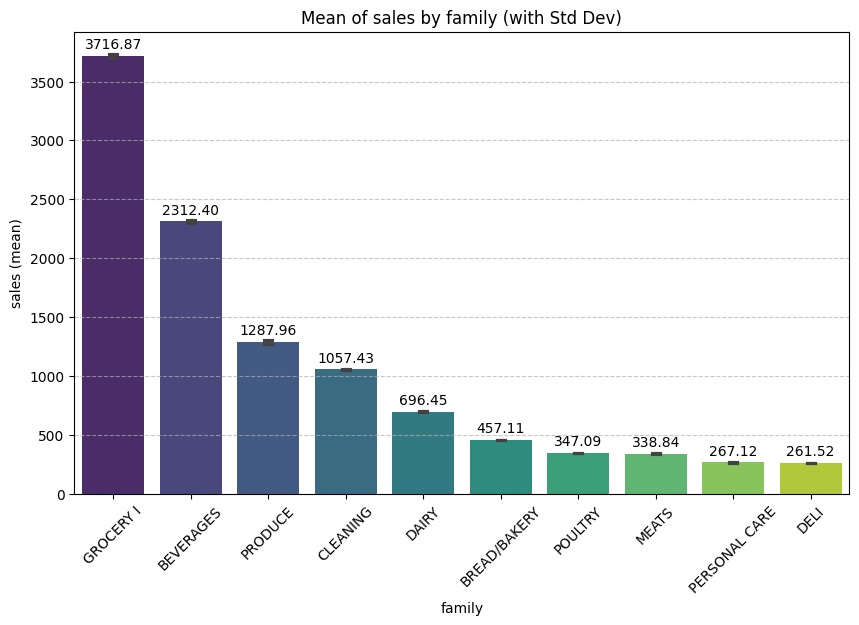

In [32]:
plot_categorical_bar(new_train_df, 'family', target_col='sales', agg_type='mean', top_k=10, tilt_angle=45)

In [33]:
new_train_df.groupby('family')['sales'].mean().sort_values(ascending=False).head(15)

family
GROCERY I           3716.873997
BEVERAGES           2312.404383
PRODUCE             1287.955629
CLEANING            1057.433401
DAIRY                696.450447
BREAD/BAKERY         457.108285
POULTRY              347.087676
MEATS                338.838892
PERSONAL CARE        267.118412
DELI                 261.523238
EGGS                 169.333808
HOME CARE            168.510951
FROZEN FOODS         155.520424
PREPARED FOODS        96.893645
LIQUOR,WINE,BEER      84.403525
Name: sales, dtype: float64

💡 Item category shows to have a great association with the sales --> `GROCERY I` shows to be the item category with the highest sales.

## Analysis of `onpromotion`

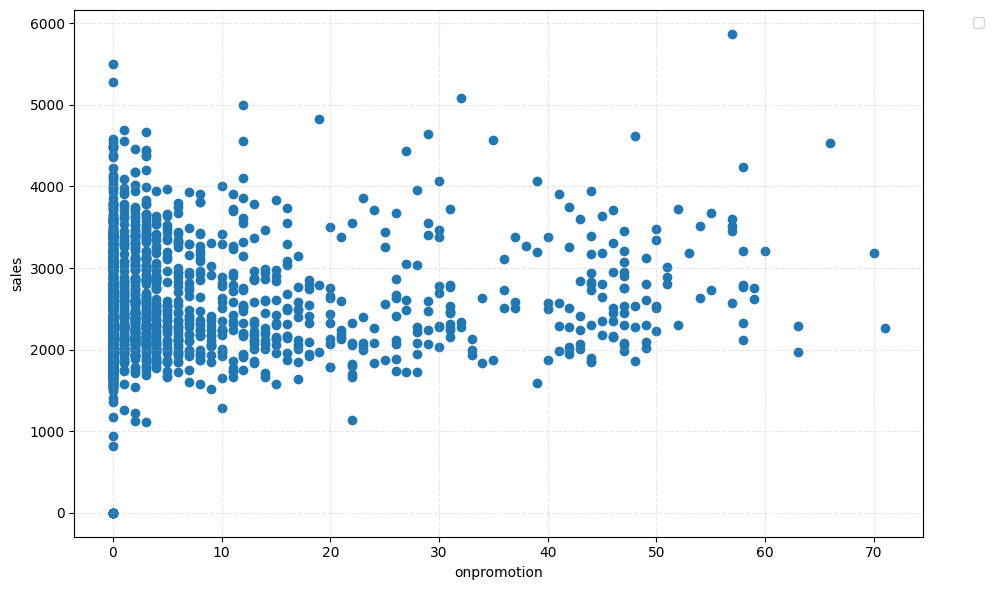

In [34]:
plot_scatter(new_train_df[(new_train_df['family']=='CLEANING')&(new_train_df['store_nbr']==44)], 'onpromotion', 'sales')

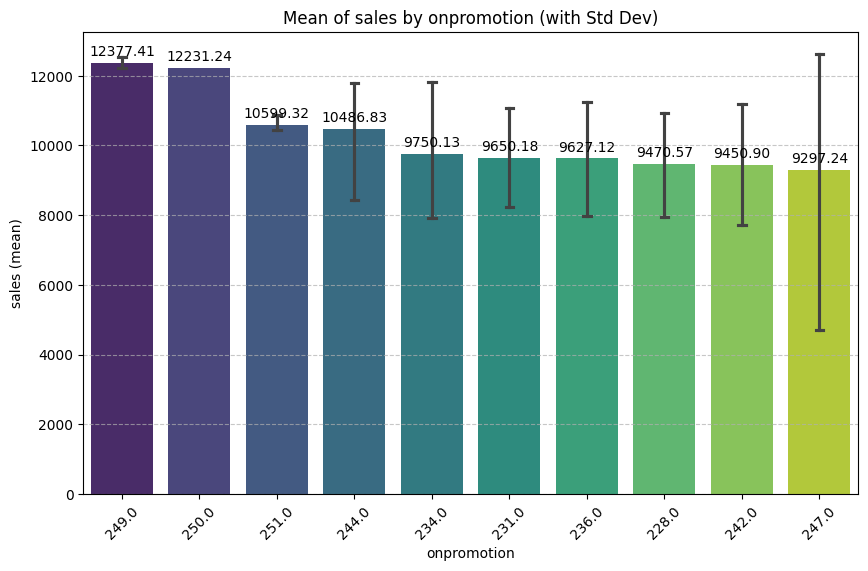

In [35]:
plot_categorical_bar(new_train_df, 'onpromotion', target_col='sales', agg_type='mean', top_k=10, tilt_angle=45)

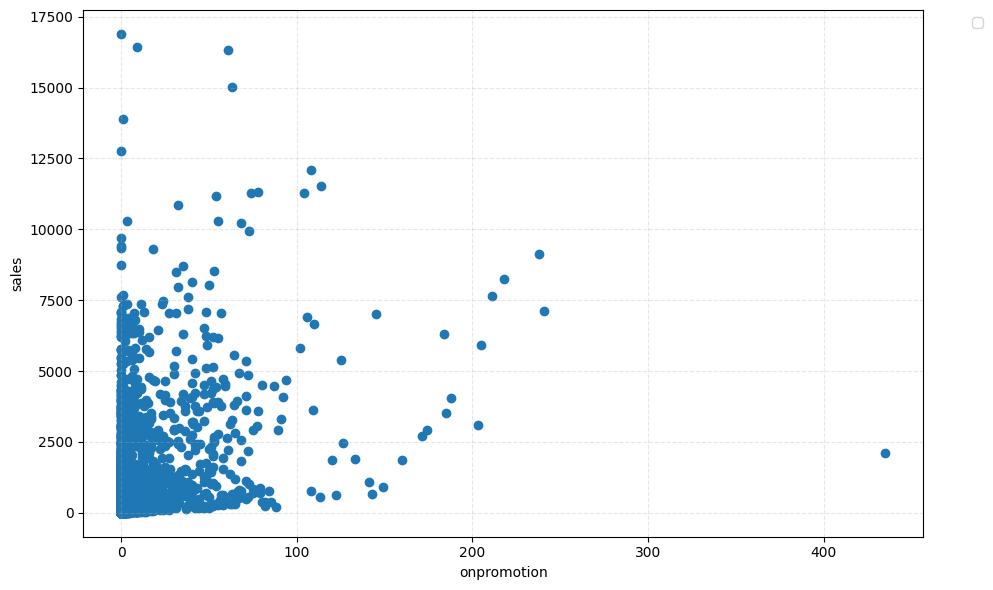

In [36]:
plot_scatter(new_train_df.sample(10_000), 'onpromotion', 'sales')

In [37]:
np.corrcoef(new_train_df['onpromotion'], new_train_df['sales'])[0][1]

np.float64(0.411405901496279)

💡`onpromotion` alone shows strong correlation with the sales - with Pearson Correlation value of 0.4.

## Analysis of `Store`

In [38]:
num_stores = new_train_df['store_nbr'].nunique()
list_stores = new_train_df['store_nbr'].unique()

print(f'Number of stores: {num_stores}')
print(f'List of stores: {list_stores}')

Number of stores: 54
List of stores: [ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]


In [39]:
stores_df.columns

Index(['store_nbr', 'city', 'state', 'type_store', 'cluster_store'], dtype='object')

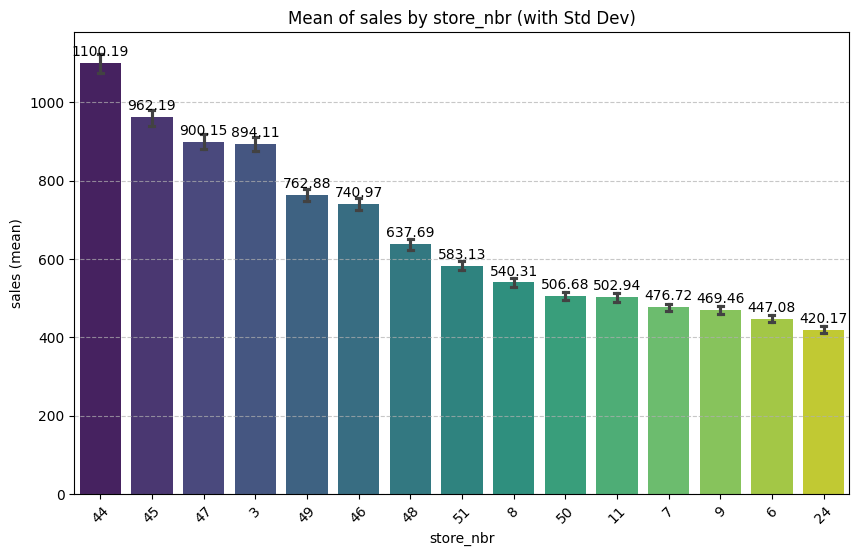

In [40]:
plot_categorical_bar(new_train_df, 'store_nbr', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

In [41]:
new_train_df['store_nbr'].value_counts().unique()

array([52734])

💡 Store id shows to have a great association with the sales --> `store 44` shows to be the store with highest sales in the period of data.
It is assumed that both `store id` and `item family` will have a major impact on sales in this prediction task. 

## Analysis of `type_store`

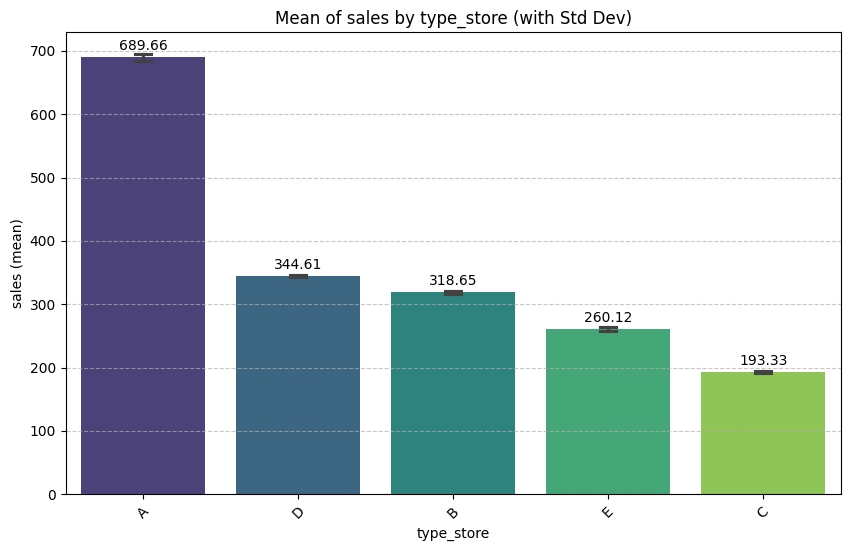

In [42]:
plot_categorical_bar(new_train_df, 'type_store', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 type of store shows strog association with sales, where `store type A` associates with highest sales, about twice as much as the second highest sales store type.

## Analysis of `cluster_store`

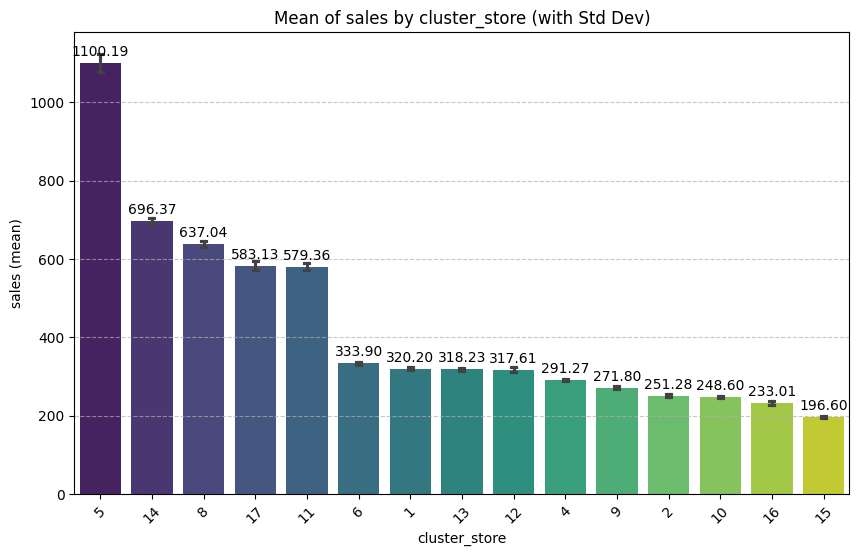

In [43]:
plot_categorical_bar(new_train_df, 'cluster_store', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 Cluster is also a strong association feature, where cluster number 5 is with the highest.

## Analysis of `city`

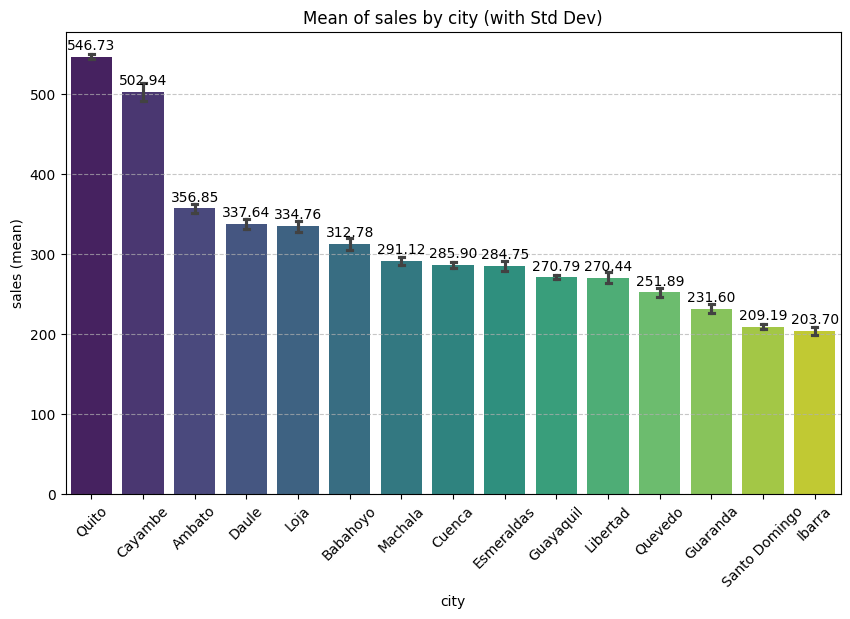

In [44]:
plot_categorical_bar(new_train_df, 'city', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 Good feature!

## Analysis of `state`

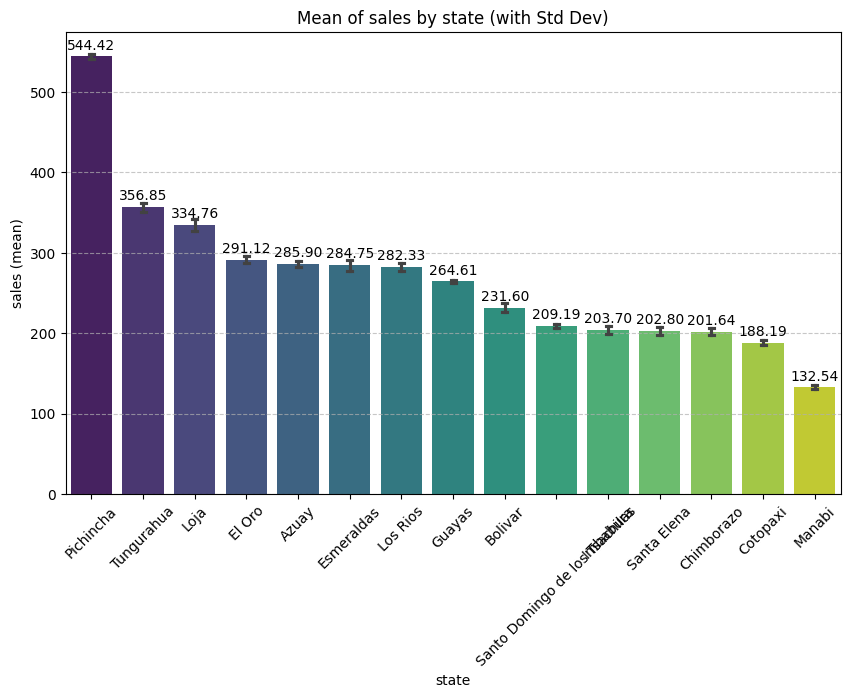

In [45]:
plot_categorical_bar(new_train_df, 'state', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 Good feature!

## Analysis of `type_holiday`

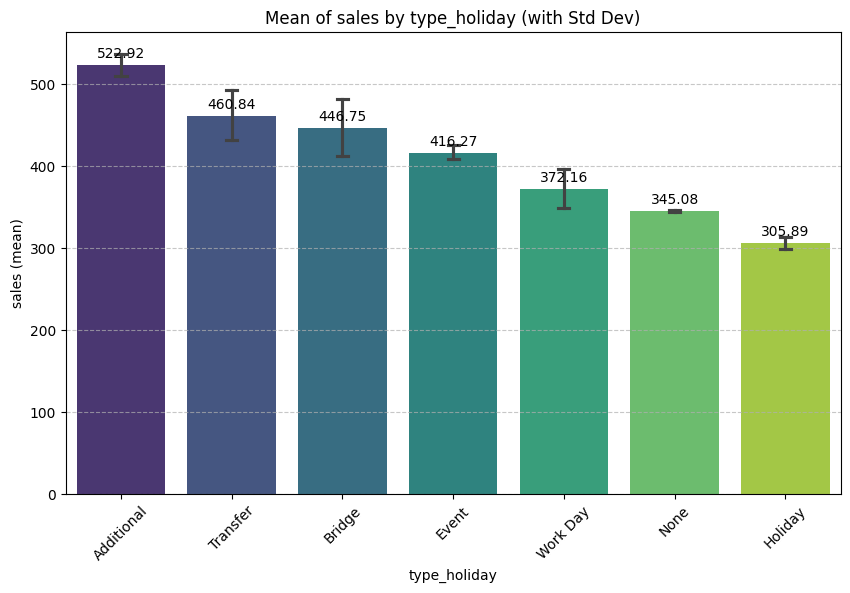

In [46]:
plot_categorical_bar(new_train_df, 'type_holiday', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 Good feature!

## Analysis of `locale_holiday`

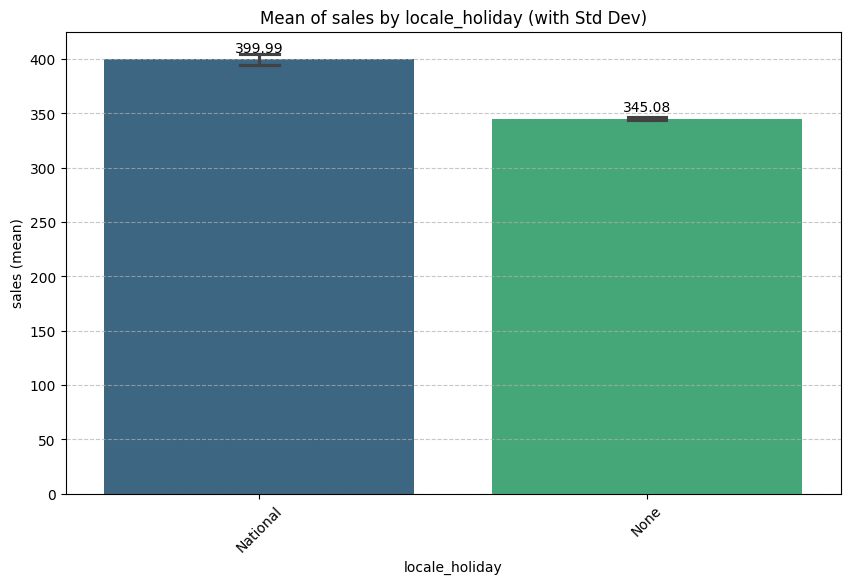

In [47]:
plot_categorical_bar(new_train_df, 'locale_holiday', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

💡 Interesting to see that local holidays associates with highest sales, rather than national holidays. I initially thought that national holidays would be stronger in sales, but I learned otherwise. It might be that local holidays are more celebrative amongs locals and therefore it becomes a more festive occasion, with maybe more discounts and more opportunities to buy. 

## Analysis of `transferred_holiday`

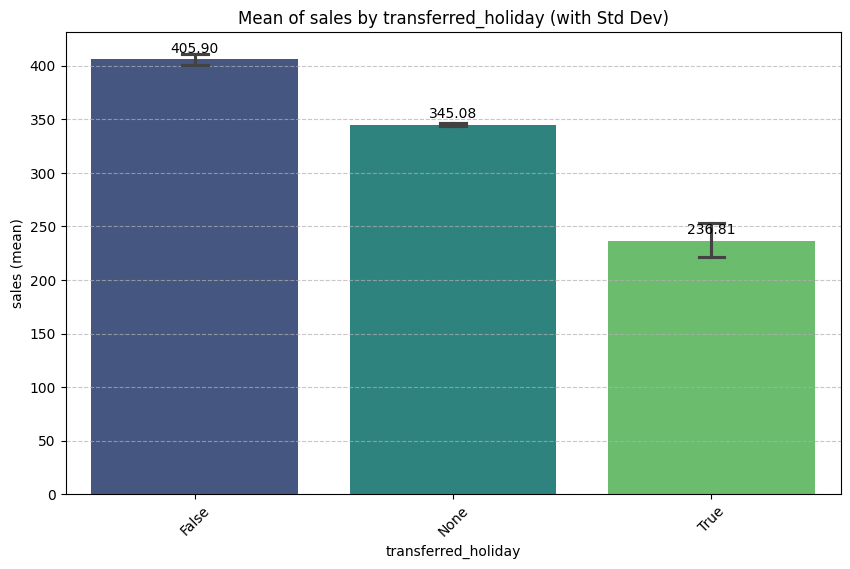

In [48]:
plot_categorical_bar(new_train_df, 'transferred_holiday', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

## Analysis of `dcoilwtico`

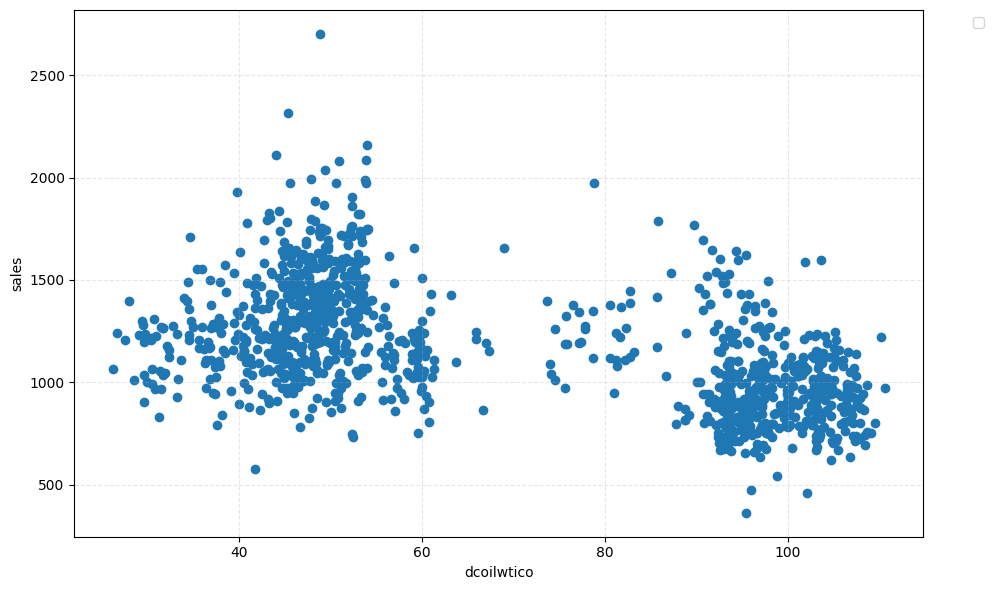

In [49]:
plot_scatter(new_train_df[(new_train_df['store_nbr']==44)&(new_train_df['family']=='BREAD/BAKERY')], 'dcoilwtico', 'sales')

In [50]:
new_train_df[['dcoilwtico', 'sales']].corr().iloc[0][1]

np.float64(-0.07841341907916469)

💡 Oil prices does not seem to be highly associated with sales, and i will disregard this feature because we cannot assume that future prices are known in advance. Therefore, considering this feature in real-world scenario may not be possible for future sales predictions. 
**In a more complex pipeline we could have tries to predict both oil prices and sales, however fot the scope of this exercise I will drop this feature.**

## Time Related Analysis

👉 In this section we will extract time-related features to allow the prediction model to learn time-based context, such as monthly trends, weekly trends and so on.


In [ ]:
new_train_df = add_time_features(new_train_df)

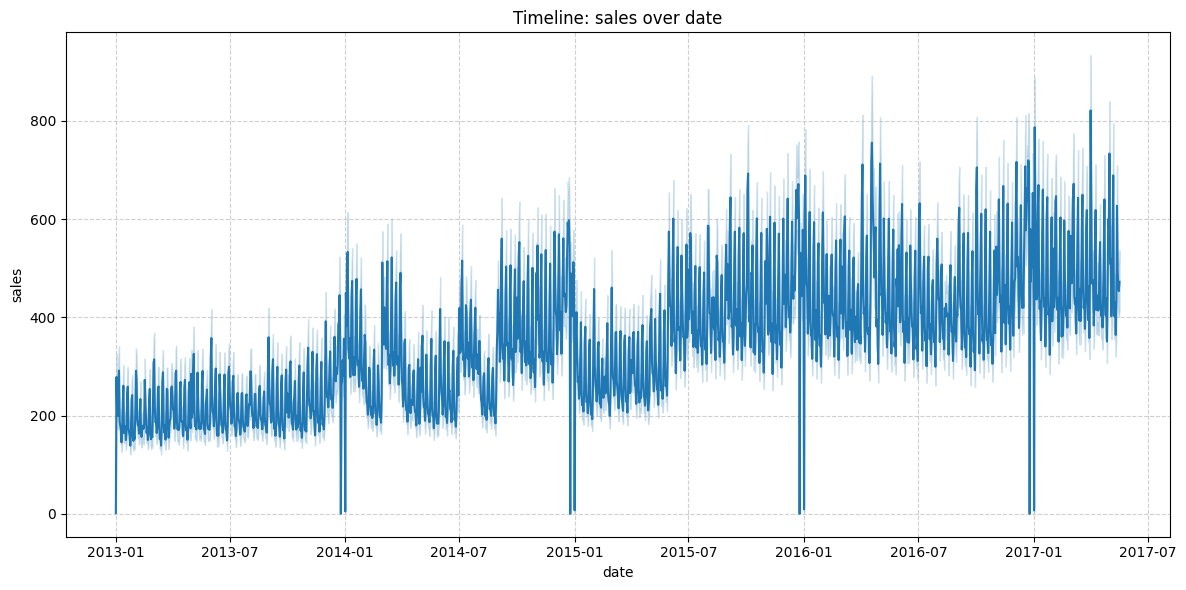

In [53]:
plot_timeline(new_train_df, 'date', 'sales')

👉 We see in the timeplot above an increasing trend over the years, suggesting an overall increasing yearly trend.

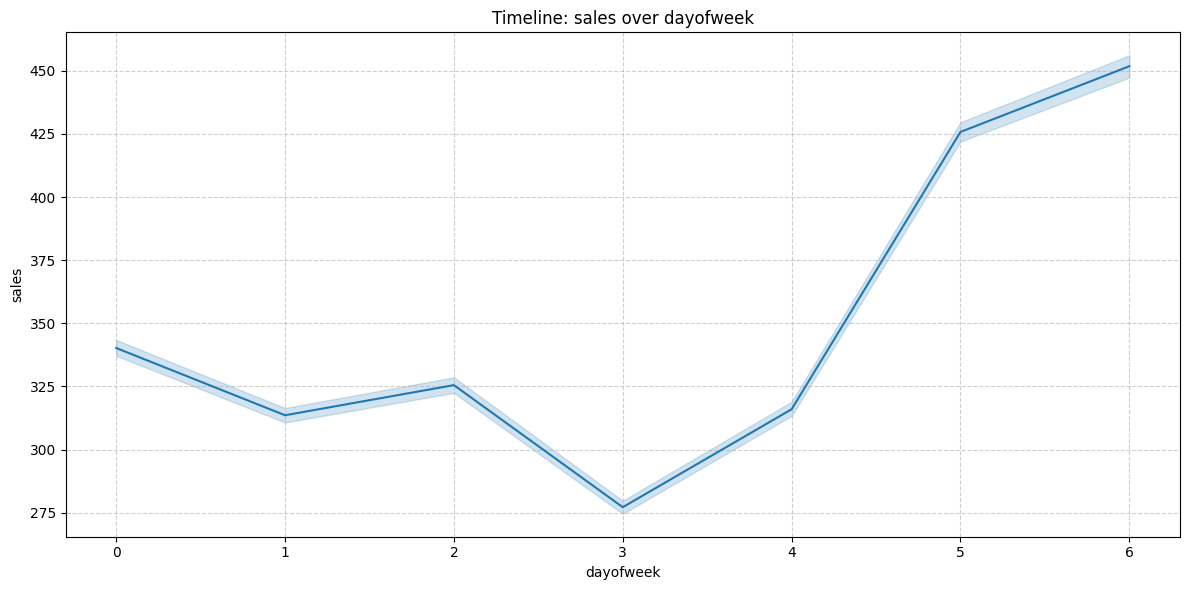

In [54]:
plot_timeline(new_train_df, 'dayofweek', 'sales')

👉 Weekends associate with higher sales!

## Specific Store Analysis

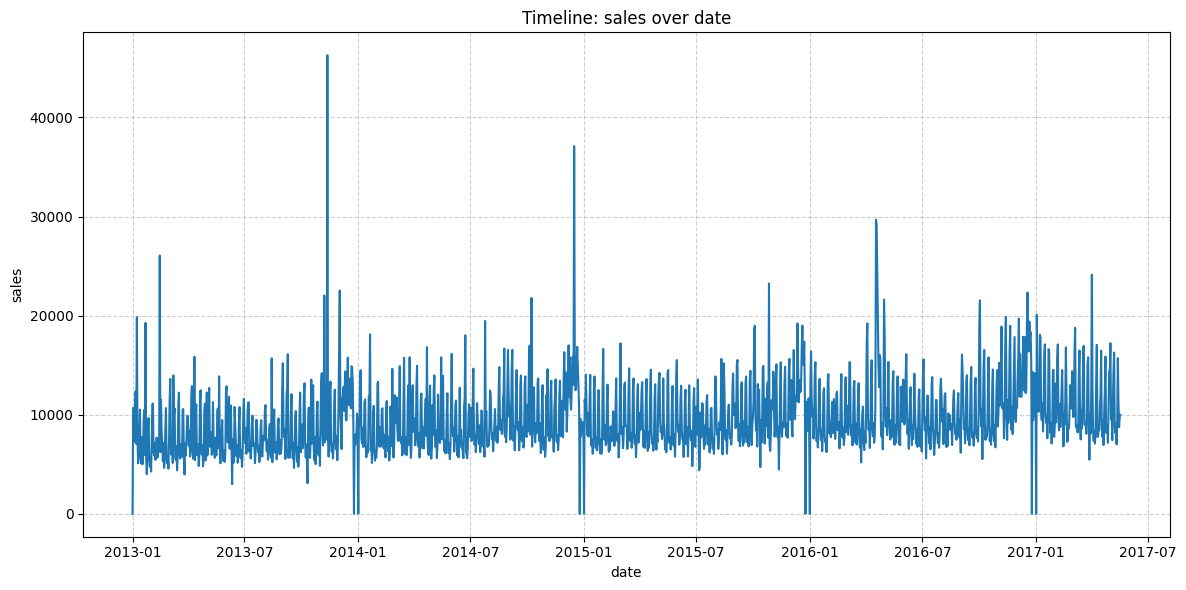

In [55]:
store_family_df = specific_df(new_train_df, 44, 'GROCERY I')
plot_timeline(store_family_df, 'date', 'sales')

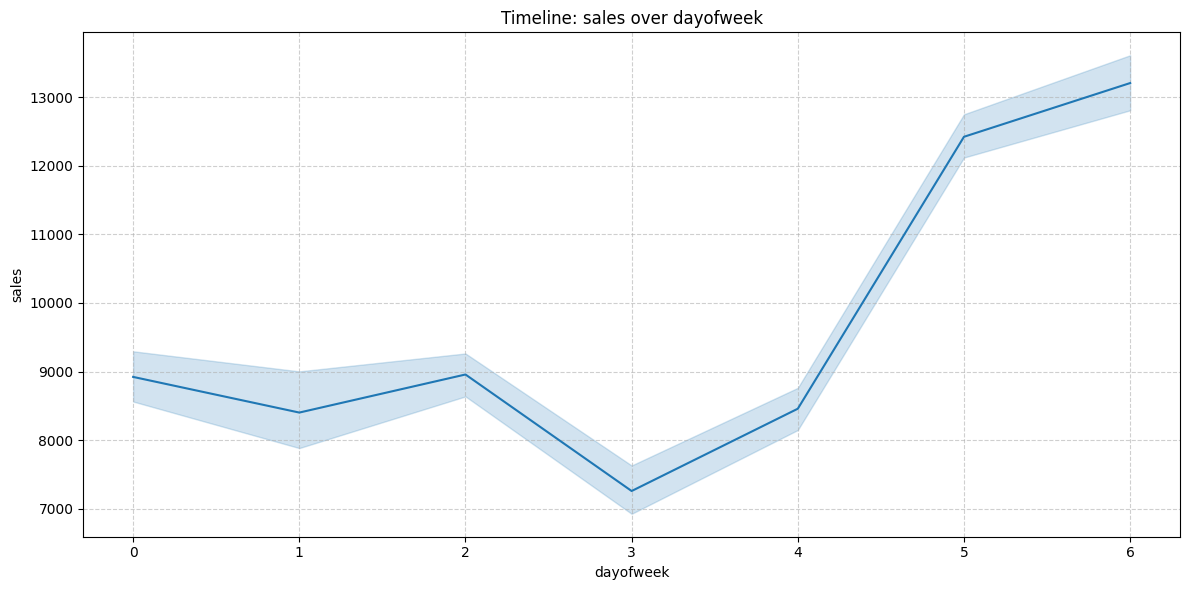

In [56]:
plot_timeline(store_family_df, 'dayofweek', 'sales')

Running decomposition (Period=365, Model=additive)...


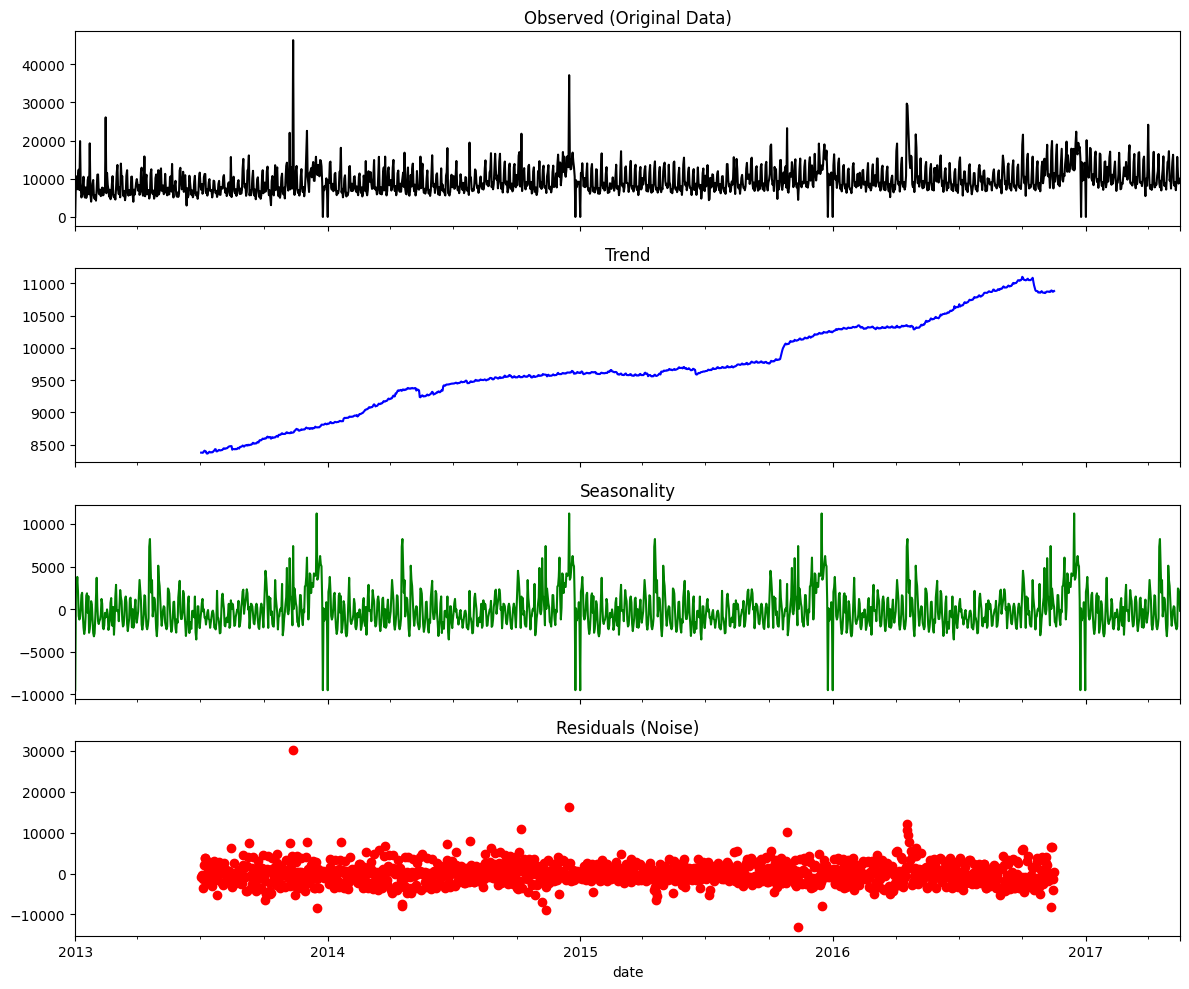

In [57]:
plot_ts_decomposition(store_family_df, 'date', 'sales', period=365, model='additive')

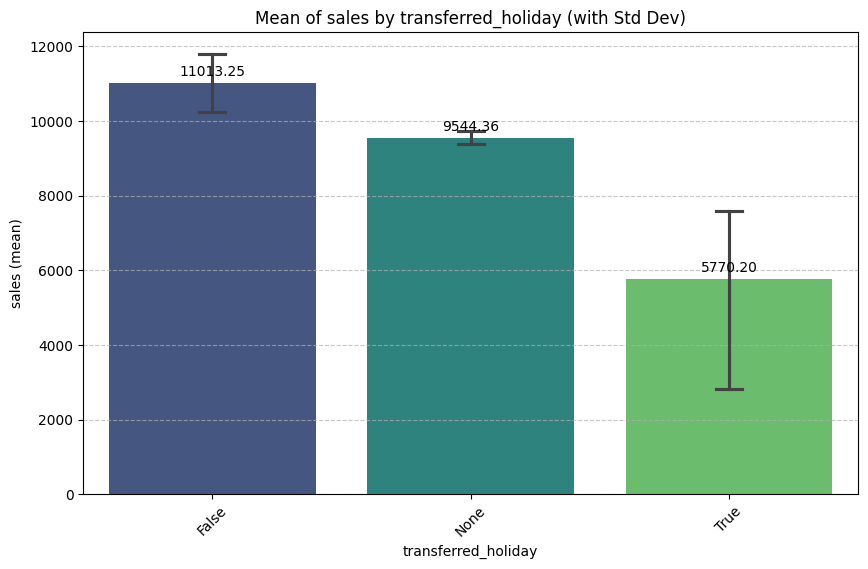

In [58]:
plot_categorical_bar(store_family_df, 'transferred_holiday', target_col='sales', agg_type='mean', top_k=15, tilt_angle=45)

## 🔍 Exploratory Data Analysis (EDA) Summary

### 1. Feature Importance & Association

* **Insight:** Most features—specifically `store_nbr`, `family`, and `onpromotion`—show a **strong association** with the target sales value.
* **Impact:** These variables are considered extremely important for the training phase. The model's ability to differentiate between a high-volume "Family" (like Beverages) and a low-volume one is foundational to its accuracy.

### 2. Strategic Exclusion: Oil Prices

* **Decision:** **Oil prices will be ignored** in this implementation.
* **Reasoning:** In a real-world scenario, we cannot assume that future daily oil prices are known in advance. Using them as a feature would create a "look-ahead" bias (data leakage) that doesn't reflect a real-world forecasting environment. To ensure the model is robust and deployable, we rely only on features available at the moment of prediction.

### 3. Temporal Dynamics & Seasonality

* **Insight:** Time-related features demonstrate powerful relationships with sales:
* **Annual Trend:** A clear **yearly increasing trend** is visible, indicating consistent growth in the retailer's operations over time.
* **Weekly Seasonality:** There is a distinct relationship between the **day of the week** and sales volume (e.g., weekend surges or mid-week lulls).


* **Impact:** Capturing these cycles is the primary goal of our engineered features (rolling means and slopes), as they allow the model to adjust for the specific "momentum" of the current week and month.


In [59]:
new_train_df.drop(columns=['dcoilwtico'], inplace=True)
test_df.drop(columns=['dcoilwtico'], inplace=True)

# Feature Engineering

The core of our forecasting strategy lies in transforming raw transactional data into meaningful signals that describe **momentum, history, and grouping context**. Since time-series models thrive on understanding past behavior to predict the future, we focus on three distinct levels of aggregation: **Product Family**, **Store**, and the intersection of **Store-Family**.

To prevent **data leakage**, all features are derived from "yesterday's" data (using a 1-day shift), ensuring the model only uses information that would actually be available at the time of a real-world prediction.

---

### 1. Hierarchical Aggregation Levels

We engineer features across three granularities to capture different sales drivers:

* **Family Level:** Captures broad consumer trends for specific product types (e.g., are "Beverages" trending up across the entire country?).
* **Store Level:** Captures the general health and traffic of a specific location (e.g., is Store #1 seeing more customers overall?).
* **Store-Family Level:** Captures highly localized product performance (e.g., how are "Cleaning Supplies" performing specifically at Store #10?).

---

### 2. Engineered Feature Types

For each of the levels above, we calculate the following metrics:

#### 📈 Rolling Averages (Smoothing)

* **7-Day & 30-Day Windows:** These features smooth out daily volatility to reveal the underlying short-term and long-term trends. They help the model distinguish between a random daily spike and a sustained increase in demand.

#### 🕒 Lagged Features (Seasonality)

* **Week-Ago & Month-Ago Lags:** By looking exactly 7 and 30 days back, we provide the model with a direct reference to weekly and monthly cycles. This is critical for capturing "same-day-last-week" effects.

#### 🚀 Velocity & Acceleration (Slopes)

* **Weekly & Monthly Slopes:** We calculate the rate of change (linear slope) over the last 7 and 30 days. This tells the model not just where sales *are*, but how fast they are *growing or shrinking*.
* **Weekly Change (Ratio):** A relative measure of growth that helps identify percentage-based shifts in consumer behavior.

---

### 3. Recursive Readiness

These features are designed for a **recursive forecasting loop**. By using `shift(1)`, we ensure that as we predict Day 1 of the test set, we can append that prediction to our history and immediately recalculate these features for Day 2, allowing the model to project trends 15 days into the future.

**Next Step:** With our features defined, we will move to **Z-score scaling** to normalize these slopes and averages, ensuring our Ridge and XGBoost models interpret the magnitudes correctly.

In [60]:
# rolling mean of sales per family
rolling_mean_df = new_train_df.groupby(['date', 'family'])['sales'].mean().reset_index()
rolling_mean_df['sales_last_day_family'] = rolling_mean_df.groupby('family')['sales'].transform(lambda x: x.shift(1))
rolling_mean_df.drop(columns=['sales'], inplace=True)
rolling_mean_df['rolling_mean_family_7'] = rolling_mean_df.groupby('family')['sales_last_day_family'].transform(lambda x: x.rolling(7).mean())
rolling_mean_df['rolling_mean_family_30'] = rolling_mean_df.groupby('family')['sales_last_day_family'].transform(lambda x: x.rolling(30).mean())
rolling_mean_df['sales_week_ago_family'] = rolling_mean_df.groupby('family')['sales_last_day_family'].transform(lambda x: x.shift(7))
rolling_mean_df['sales_month_ago_family'] = rolling_mean_df.groupby('family')['sales_last_day_family'].transform(lambda x: x.shift(30))
rolling_mean_df['weekly_change_family'] = rolling_mean_df['sales_last_day_family'] / rolling_mean_df['sales_week_ago_family']
rolling_mean_df['weekly_slope_family'] = (rolling_mean_df['sales_last_day_family'] - rolling_mean_df['sales_week_ago_family']) / 7
rolling_mean_df['monthly_slope_family'] = (rolling_mean_df['sales_last_day_family'] - rolling_mean_df['sales_month_ago_family']) / 30

# rolling mean of sales per family & store
rolling_mean_store_family_df = new_train_df.groupby(['date', 'store_nbr', 'family'])['sales'].mean().reset_index()
rolling_mean_store_family_df['sales_last_day_store_family'] = rolling_mean_store_family_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1))
rolling_mean_store_family_df.drop(columns=['sales'], inplace=True)
rolling_mean_store_family_df['rolling_mean_store_family_7'] = rolling_mean_store_family_df.groupby(['store_nbr', 'family'])['sales_last_day_store_family'].transform(lambda x: x.rolling(7).mean())
rolling_mean_store_family_df['rolling_mean_store_family_30'] = rolling_mean_store_family_df.groupby(['store_nbr', 'family'])['sales_last_day_store_family'].transform(lambda x: x.rolling(30).mean())
rolling_mean_store_family_df['sales_week_ago_store_family'] = rolling_mean_store_family_df.groupby(['store_nbr', 'family'])['sales_last_day_store_family'].transform(lambda x: x.shift(7))
rolling_mean_store_family_df['sales_month_ago_store_family'] = rolling_mean_store_family_df.groupby(['store_nbr', 'family'])['sales_last_day_store_family'].transform(lambda x: x.shift(30))
rolling_mean_store_family_df['weekly_change_store_family'] = rolling_mean_store_family_df['sales_last_day_store_family'] / rolling_mean_store_family_df['sales_week_ago_store_family']
rolling_mean_store_family_df['weekly_slope_store_family'] = (rolling_mean_store_family_df['sales_last_day_store_family'] - rolling_mean_store_family_df['sales_week_ago_store_family']) / 7
rolling_mean_store_family_df['monthly_slope_store_family'] = (rolling_mean_store_family_df['sales_last_day_store_family'] - rolling_mean_store_family_df['sales_month_ago_store_family']) / 30

# rolling mean of sales per store
rolling_mean_store_df = new_train_df.groupby(['date', 'store_nbr'])['sales'].mean().reset_index()
rolling_mean_store_df['sales_last_day_store'] = rolling_mean_store_df.groupby('store_nbr')['sales'].transform(lambda x: x.shift(1))
rolling_mean_store_df.drop(columns=['sales'], inplace=True)
rolling_mean_store_df['rolling_mean_store_7'] = rolling_mean_store_df.groupby('store_nbr')['sales_last_day_store'].transform(lambda x: x.rolling(7).mean())
rolling_mean_store_df['rolling_mean_store_30'] = rolling_mean_store_df.groupby('store_nbr')['sales_last_day_store'].transform(lambda x: x.rolling(30).mean())
rolling_mean_store_df['sales_week_ago_store'] = rolling_mean_store_df.groupby('store_nbr')['sales_last_day_store'].transform(lambda x: x.shift(7))
rolling_mean_store_df['sales_month_ago_store'] = rolling_mean_store_df.groupby('store_nbr')['sales_last_day_store'].transform(lambda x: x.shift(30))
rolling_mean_store_df['weekly_change_store'] = rolling_mean_store_df['sales_last_day_store'] / rolling_mean_store_df['sales_week_ago_store']
rolling_mean_store_df['weekly_slope_store'] = (rolling_mean_store_df['sales_last_day_store'] - rolling_mean_store_df['sales_week_ago_store']) / 7
rolling_mean_store_df['monthly_slope_store'] = (rolling_mean_store_df['sales_last_day_store'] - rolling_mean_store_df['sales_month_ago_store']) / 30


In [ ]:
# merge dfs
new_train_df_w_time = new_train_df.merge(rolling_mean_df, how='left', on=['date', 'family'])
new_train_df_w_time = new_train_df_w_time.merge(rolling_mean_store_family_df, how='left', on=['date', 'store_nbr', 'family'])
new_train_df_w_time = new_train_df_w_time.merge(rolling_mean_store_df, how='left', on=['date', 'store_nbr'])

#1st of january
new_train_df_w_time['is_first_january'] = new_train_df_w_time['date'].dt.day == 1


,index,date,store_nbr,family,sales,onpromotion,city,state,type_store,cluster_store,...,monthly_slope_store_family,sales_last_day_store,rolling_mean_store_7,rolling_mean_store_30,sales_week_ago_store,sales_month_ago_store,weekly_change_store,weekly_slope_store,monthly_slope_store,is_first_january
265064,265064,2013-05-29,46,DAIRY,525.0,0.0,Quito,Pichincha,A,14,...,-29.200000,332.290212,475.775174,494.350440,326.833455,848.564213,1.016696,0.779537,-17.209133,False
1370732,1370732,2015-02-09,2,FROZEN FOODS,114.0,1.0,Quito,Pichincha,D,13,...,-1.473233,372.928818,303.675377,307.656994,468.698061,291.794667,0.795670,-13.681320,2.704472,False
788574,788574,2014-03-19,35,CELEBRATION,1.0,0.0,Playas,Guayas,C,3,...,0.033333,137.024012,142.091078,137.108071,116.303227,131.946637,1.178162,2.960112,0.169246,False
2619112,2619112,2017-01-09,47,BABY CARE,0.0,0.0,Quito,Pichincha,A,14,...,0.000000,2020.930243,1615.438852,1364.579230,0.000000,1145.175606,inf,288.704320,29.191821,False
639258,639258,2013-12-25,45,HOME AND KITCHEN I,0.0,0.0,Quito,Pichincha,A,11,...,0.000000,799.962213,958.526840,760.288336,732.300243,955.191727,1.092396,9.665996,-5.174317,False
1027826,1027826,2014-07-31,48,DAIRY,1022.0,1.0,Quito,Pichincha,A,14,...,-8.700000,472.124333,579.667433,646.632515,502.495879,456.971212,0.939559,-4.338792,0.505104,False
1518628,1518628,2015-05-03,2,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,...,0.000000,404.656606,299.433026,301.183391,364.938485,312.846333,1.108835,5.674017,3.060342,False
2589098,2589098,2016-12-23,54,HOME APPLIANCES,1.0,0.0,El Carmen,Manabi,C,3,...,0.000000,314.709000,319.922229,273.459227,209.798273,220.460182,1.500055,14.987247,3.141627,False
1275568,1275568,2014-12-17,49,LADIESWEAR,17.0,0.0,Quito,Pichincha,A,11,...,-0.800000,1380.366636,1113.834013,948.979060,833.411726,1241.342182,1.656284,78.136416,4.634148,False
1149937,1149937,2014-10-08,24,LADIESWEAR,8.0,0.0,Guayaquil,Guayas,D,1,...,-0.433333,416.320999,489.023260,474.074610,419.990364,530.830879,0.991263,-0.524195,-3.816996,False


# Correlation MX

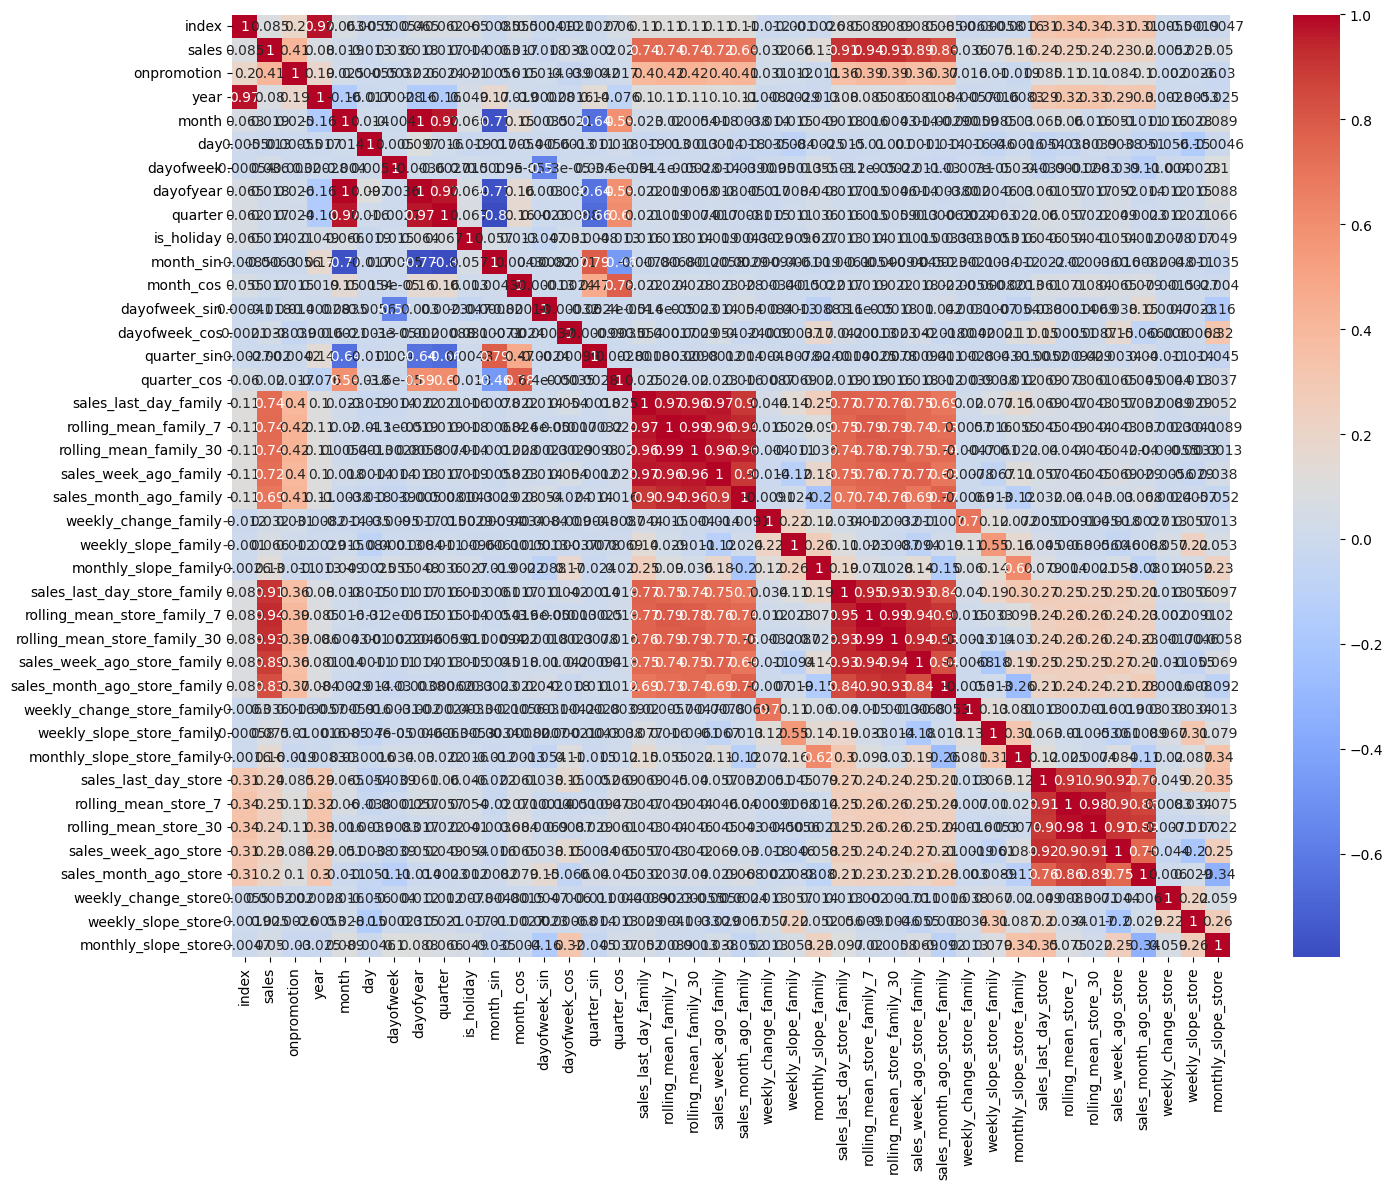

In [63]:
numerical_cols = [x for x in new_train_df_w_time.describe().columns if x not in ['id', 'date', 'store_nbr', 'cluster_store']] 
# new_train_df_w_time[numerical_cols].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(new_train_df_w_time[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

In [64]:
new_train_df_w_time[numerical_cols].corr()['sales'].sort_values(ascending=False)

sales                           1.000000
rolling_mean_store_family_7     0.935477
rolling_mean_store_family_30    0.927448
sales_last_day_store_family     0.912858
sales_week_ago_store_family     0.887618
sales_month_ago_store_family    0.834289
rolling_mean_family_7           0.744452
rolling_mean_family_30          0.739520
sales_last_day_family           0.739380
sales_week_ago_family           0.724185
sales_month_ago_family          0.691374
onpromotion                     0.411406
rolling_mean_store_7            0.246410
rolling_mean_store_30           0.243744
sales_last_day_store            0.238331
sales_week_ago_store            0.228504
sales_month_ago_store           0.204871
monthly_slope_store_family      0.157034
monthly_slope_family            0.127404
index                           0.085140
year                            0.080098
weekly_slope_store_family       0.074628
weekly_slope_family             0.065817
monthly_slope_store             0.050041
dayofweek_cos   

## EDA with latest new features

This analysis focus on the time-relates sales features that were engineered above.

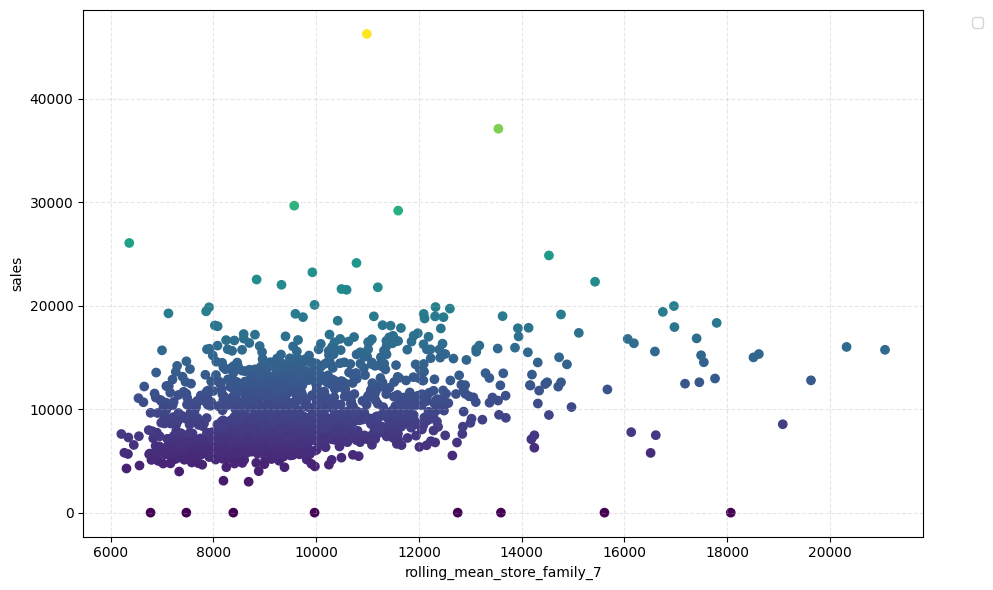

In [65]:
new_specific = specific_df(new_train_df_w_time, 44, 'GROCERY I')
plot_scatter(new_specific, 'rolling_mean_store_family_7', 'sales', 'sales')

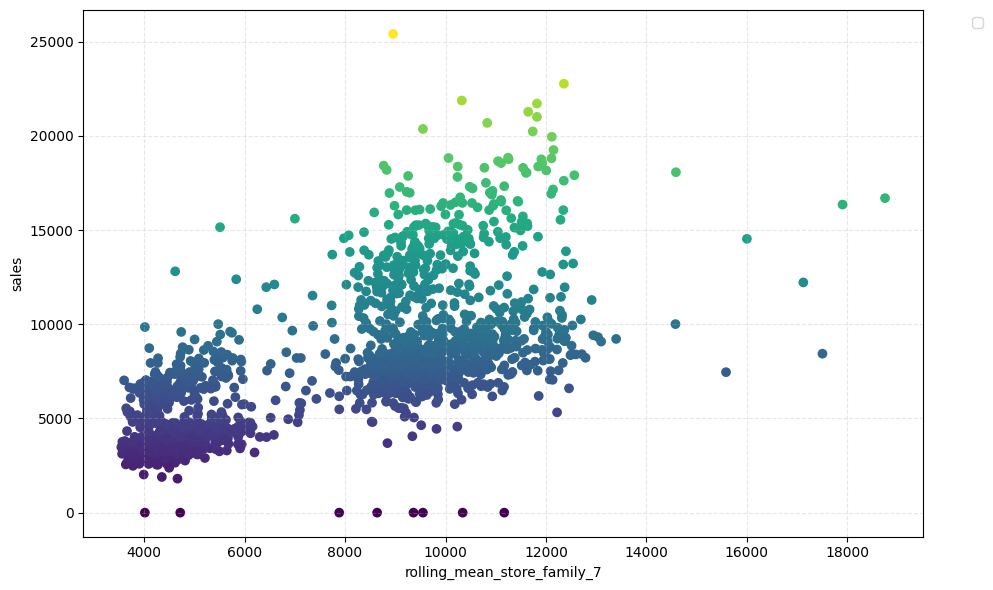

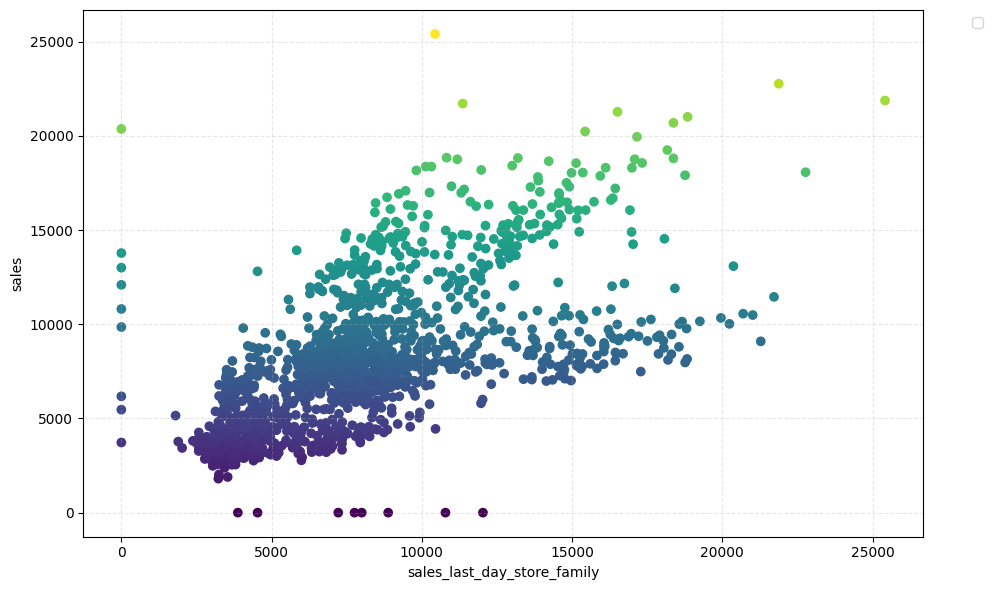

In [66]:
new_specific = specific_df(new_train_df_w_time, 44, 'BEVERAGES')
plot_scatter(new_specific, 'rolling_mean_store_family_7', 'sales', 'sales')
plot_scatter(new_specific, 'sales_last_day_store_family', 'sales', 'sales')

## ⏳ Time-Series Feature Analysis Summary

👉 Strong Predictive Power of Historical Features Both correlation analysis and visual inspection confirm that engineered historical features are the strongest predictors of future sales. For instance, the rolling_mean_store_family_7 feature (representing average sales for a specific product family at a specific store over the prior week) shows a correlation of 0.935, indicating an almost perfect positive linear relationship with the target. This high coefficient suggests that recent local history is the primary driver of future performance.

👉 Multicollinearity and Group Dynamics The correlation matrix reveals high internal correlation (multicollinearity) between features within the same aggregation groups (e.g., a 7-day rolling mean is highly correlated with a 30-day rolling mean). This suggests that while all these features are strong individually, the model may benefit from dimensionality reduction or regularization (like Ridge) to prevent redundant information from inflating the importance of specific time windows. Feature selection should focus on identifying the most unique signals from each group (Family vs. Store vs. Family-Store) rather than treating all lags as independent variables.

# Evaluate Models


In [67]:
target_col = 'sales'
numerical_cols = [x for x in new_train_df_w_time.describe().columns if x not in ['id', 'date', 'store_nbr', 'cluster_store']] 
numerical_features = [x for x in numerical_cols if x not in ['sales', 'is_holiday', 'is_first_january', 'index']]
categorical_features = [x for x in new_train_df_w_time.columns if x not in (numerical_features + ['id', 'date', 'sales', 'index'])]

### 🛠️ Final Training Preprocessing

We have now established the final preprocessing pipeline to prepare the data for the learning algorithms. This includes **feature scaling** to ensure all numerical inputs are on a comparable magnitude: **Min-Max scaling** is applied to features with finite, defined ranges, while **Z-score normalization** (StandardScaler) is used for infinite or unbounded numerical features. Additionally, we employ **One-Hot Encoding** (via `get_dummies`) for categorical variables. This step is essential for evaluating baseline models like **Linear Regression with Ridge regularization**, which require numerical matrices and are highly sensitive to the scale of the input features.

In [70]:
X_train = new_train_df_w_time[categorical_features + numerical_features]
y_train = new_train_df_w_time[target_col]

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)

cols_to_min_max = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter']
cols_not_scale = ['month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'quarter_sin', 'quarter_cos']
cols_to_z_normalize = [col for col in numerical_features if col not in (cols_not_scale+cols_to_min_max)]

minmax_scaler = MinMaxScaler()
X_train[cols_to_min_max] = minmax_scaler.fit_transform(X_train[cols_to_min_max])

z_scaler = StandardScaler()
X_train[cols_to_z_normalize] = z_scaler.fit_transform(X_train[cols_to_z_normalize])


X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)

### 📉 Evaluating Models: XGBoost & Linear Regression

With the data fully prepared, we move to the evaluation of two distinct modeling architectures:

👉 **Linear Regression (Ridge):** Serving as our traditional baseline, this model is designed to capture the fundamental linear relationships between our engineered features and the target sales. The inclusion of Ridge (L2) regularization helps manage the multicollinearity we identified during the EDA phase.

👉 **XGBoost:** As a gradient-boosted decision tree framework, XGBoost is capable of capturing complex, non-linear interactions that a linear model might miss. It is widely recognized for its robustness and state-of-the-art performance in tabular time-series forecasting tasks.

We will utilize **RMSE (Root Mean Squared Error)** as our primary evaluation metric. This metric is particularly useful here as it penalizes larger errors more heavily, ensuring our forecast remains reliable. The results of this comparison will determine which model we select for the subsequent **fine-tuning stage**, where we will perform advanced feature selection and hyper-parameter optimization.


In [109]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

predictions = np.clip(lr_model.predict(X_train), 0, None) # Clip negative predictions to 0.0
lr_results = pd.DataFrame({'actual': y_train, 'predicted': predictions, 'date': new_train_df_w_time['date']})

## We know that sales on January 1st and December 25th are 0 for all stores and categories.
januaries_1st = ["2015-01-01", "2016-01-01", "2017-01-01", "2018-01-01", "2019-01-01"]
christmans_dates = ["2015-12-25", "2016-12-25", "2017-12-25", "2018-12-25", "2019-12-25"]
lr_results.loc[(lr_results['date'].isin(januaries_1st+christmans_dates)), 'predicted'] = 0
corrected_predictions = lr_results['predicted']

print(f"TrainRMSE: {root_mean_squared_error(y_train, corrected_predictions)}")
print(f"MAE: {mean_absolute_error(y_train, corrected_predictions)}")


TrainRMSE: 345.9501314846078
MAE: 95.34754088355653


In [73]:
xgb_model = XGBRegressor(n_estimators=80, learning_rate=0.1, n_jobs=-1, random_state=42, reg_lambda=100)
xgb_model.fit(X_train, y_train)

predictions = np.clip(xgb_model.predict(X_train), 0, None) # Clip negative predictions to 0.0
xgb_results = pd.DataFrame({'actual': y_train, 'predicted': predictions, 'date': new_train_df_w_time['date']})

## We know that sales on January 1st and December 25th are 0 for all stores and categories.
januaries_1st = ["2015-01-01", "2016-01-01", "2017-01-01", "2018-01-01", "2019-01-01"]
christmans_dates = ["2015-12-25", "2016-12-25", "2017-12-25", "2018-12-25", "2019-12-25"]
xgb_results.loc[(xgb_results['date'].isin(januaries_1st+christmans_dates)), 'predicted'] = 0
corrected_predictions = xgb_results['predicted']

print(f"RMSE: {root_mean_squared_error(y_train, corrected_predictions)}")
print(f"MAE: {mean_absolute_error(y_train, corrected_predictions)}")


RMSE: 242.83505188148968
MAE: 54.40219465178048


## Preprocess test data features

We now preprocess the test data for time-based only features (month, day, dayofweek...)

In [ ]:
test_df = add_time_features(test_df)

Later in the test prediction pipeline, we utiliaze the `engineer features` function (defined in the utils.py file) which performs a feature engineering for sales history based on the known (or predicted) datae. The pipleine will look ahead a single day each time, engineering for that day the previous known or predicted sales data, serving as the ground truth for the next predictions. 

In [ ]:
ridge_model, minmax_scaler, z_scaler = prepare_and_fit_train(xgb, new_train_df_w_time, categorical_features, numerical_features)
predict_test(ridge_model, minmax_scaler, z_scaler, test_df, new_train_df_w_time, categorical_features, numerical_features)

RMSE: 345.99622002669827
MAE: 95.24924844165189


Predicting test set: 100%|██████████| 90/90 [03:06<00:00,  2.07s/it]

RMSE: 362.21860220947855
MAE: 126.96657211751277


## Feature Engineering

In [ ]:
features_by_importance = {
    'lr': pd.DataFrame({'feature': lr_model.feature_names_in_, 'importance': lr_model.coef_}),
    'xgb': pd.DataFrame({'feature': xgb_model.feature_names_in_, 'importance': xgb_model.feature_importances_})
    }


top_features = []
for model in ['lr', 'xgb']:
    top_k = 25
    # display(features_by_importance[model].sort_values(by='importance', ascending=False).head(top_k))
    top_features.extend(features_by_importance[model].sort_values(by='importance', ascending=False).head(top_k)['feature'].tolist())

top_features = list(set(top_features))

In [ ]:
def top_k_features_xgb(top_k=25):
    return features_by_importance['xgb'].sort_values(by='importance', ascending=False).head(top_k)['feature'].tolist()
top_xgb_22 = top_k_features_xgb(22)

## XGBoost on top features

In [ ]:
X_train_top_xgb = X_train[top_xgb_22]
xgb_model = XGBRegressor(n_estimators=80, learning_rate=0.1, n_jobs=-1, random_state=42, reg_lambda=100)
xgb_model.fit(X_train_top_xgb, y_train)

predictions = np.clip(xgb_model.predict(X_train_top_xgb), 0, None) # Clip negative predictions to 0.0

xgb_results = pd.DataFrame({'actual': y_train, 'predicted': predictions, 'date': new_train_df_w_time['date']})
januaries_1st = ["2015-01-01", "2016-01-01", "2017-01-01", "2018-01-01", "2019-01-01"]
christmans_dates = ["2015-12-25", "2016-12-25", "2017-12-25", "2018-12-25", "2019-12-25"]

xgb_results.loc[(xgb_results['date'].isin(januaries_1st+christmans_dates)), 'predicted'] = 0
corrected_predictions = xgb_results['predicted']

print(f"RMSE: {root_mean_squared_error(y_train, corrected_predictions)}")
print(f"MAE: {mean_absolute_error(y_train, corrected_predictions)}")


RMSE: 259.79087214584615
MAE: 57.98003584108261


In [ ]:
dates_to_predict = sorted(test_df['date'].unique())
dates_trained_on = sorted(new_train_df_w_time['date'].unique())

current_date = dates_to_predict[0]
test_try = test_df[test_df['date']==current_date]
test_try.drop(columns=['id'], inplace=True, errors='ignore')
test_try_columns = test_try.columns

X_last_two_months = new_train_df_w_time[new_train_df_w_time['date'].isin(dates_trained_on[-60:])][test_try_columns]
engineered_df = pd.concat([X_last_two_months, test_try], axis=0)
engineered_df = engineer_features(engineered_df)
engineered_test = engineered_df[engineered_df['date']==current_date]

X_test = engineered_test[categorical_features + numerical_features]
y_test = engineered_test[target_col]
[x for x in new_train_df_w_time.columns if x not in X_test.columns]
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(0, inplace=True)

cols_to_min_max = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter']
cols_not_scale = ['month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'quarter_sin', 'quarter_cos']
cols_to_z_normalize = [col for col in numerical_features if col not in (cols_not_scale + cols_to_min_max)]

scaler = MinMaxScaler()
X_test[cols_to_min_max] = scaler.fit_transform(X_test[cols_to_min_max])

scaler = StandardScaler()
X_test[cols_to_z_normalize] = scaler.fit_transform(X_test[cols_to_z_normalize])


X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
# X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# lr_test_predictions = np.clip(lr_model.predict(X_test), 0, None) # Clip negative predictions to 0.0
# lr_test_results = pd.DataFrame({'actual': y_test, 'predicted': lr_test_predictions, 'date': [current_date] * len(lr_test_predictions)})
# lr_test_results.loc[(lr_results['date'].isin(januaries_1st+christmans_dates)), 'predicted'] = 0
# lr_corrected_test_predictions = lr_results['predicted']

# print(f"RMSE: {root_mean_squared_error(y_test, lr_test_results['predicted'])}")
# print(f"MAE: {mean_absolute_error(y_test, lr_test_results['predicted'])}")

# xgb_test_predictions = np.clip(xgb_model.predict(X_test), 0, None) # Clip negative predictions to 0.0
# xgb_test_results = pd.DataFrame({'actual': y_test, 'predicted': xgb_test_predictions, 'date': [current_date] * len(xgb_test_predictions)})
# xgb_test_results.loc[(xgb_results['date'].isin(januaries_1st+christmans_dates)), 'predicted'] = 0
# xgb_corrected_test_predictions = xgb_results['predicted']

# print(f"RMSE: {root_mean_squared_error(y_test, xgb_test_results['predicted'])}")
# print(f"MAE: {mean_absolute_error(y_test, xgb_test_results['predicted'])}")

Index(['onpromotion', 'dcoilwtico', 'year', 'month', 'day', 'dayofweek',
       'dayofyear', 'quarter', 'month_sin', 'month_cos',
       ...
       'cluster_store_8', 'cluster_store_9', 'cluster_store_10',
       'cluster_store_11', 'cluster_store_12', 'cluster_store_13',
       'cluster_store_14', 'cluster_store_15', 'cluster_store_16',
       'cluster_store_17'],
      dtype='object', length=179)


In [ ]:
[x for x in X_test.columns if 'holiday' in x]

[]

# final fit & predictions

## Junk tests

In [ ]:
test_train = X_train[top_features[25:-2]]

xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, n_jobs=-1, random_state=42, reg_lambda=1000)
xgb_model.fit(test_train, y_train)

predictions = np.clip(xgb_model.predict(test_train), 0, None) # Clip negative predictions to 0.0

xgb_results = pd.DataFrame({'actual': y_train, 'predicted': predictions, 'date': new_train_df_w_time['date']})
januaries_1st = ["2015-01-01", "2016-01-01", "2017-01-01", "2018-01-01", "2019-01-01"]
christmans_dates = ["2015-12-25", "2016-12-25", "2017-12-25", "2018-12-25", "2019-12-25"]

xgb_results.loc[(xgb_results['date'].isin(januaries_1st+christmans_dates)), 'predicted'] = 0
corrected_predictions = xgb_results['predicted']

print(f"RMSE: {root_mean_squared_error(y_train, corrected_predictions)}")
print(f"MAE: {mean_absolute_error(y_train, corrected_predictions)}")

test_test = X_test[top_features[25:-2]]

xgb_test_predictions = np.clip(xgb_model.predict(test_test), 0, None) # Clip negative predictions to 0.0
xgb_test_results = pd.DataFrame({'actual': y_test, 'predicted': xgb_test_predictions, 'date': [current_date] * len(xgb_test_predictions)})
xgb_test_results.loc[(xgb_results['date'].isin(januaries_1st+christmans_dates)), 'predicted'] = 0
xgb_corrected_test_predictions = xgb_results['predicted']

print(f"RMSE: {root_mean_squared_error(y_test, xgb_test_results['predicted'])}")
print(f"MAE: {mean_absolute_error(y_test, xgb_test_results['predicted'])}")

RMSE: 291.2663797057393
MAE: 64.79562437836381
RMSE: 167.24171899500374
MAE: 60.68062623971599


# Junk...

# Save results and models

In [ ]:
import joblib
import os

# Create a folder to keep things organized
os.makedirs('artifacts', exist_ok=True)

# 1. Save the Results Dataframe
# CSV is human-readable; index=False avoids saving the row numbers
results_df.to_csv('artifacts/forecast_results.csv', index=False)
print("Results saved to artifacts/forecast_results.csv")

# 2. Save the Models & Metadata
# We save the whole pack so we don't forget which columns went into the scaler
# models_pack = (lr_model, xgb_model, scaler, feature_cols, num_cols_to_scale)
joblib.dump(models_pack, 'artifacts/models_pack.pkl')
print("Models and Scaler saved to artifacts/models_pack.pkl")

Results saved to artifacts/forecast_results.csv
Models and Scaler saved to artifacts/models_pack.pkl


# Load Results and Models

In [ ]:

# 1. Load the Results
results_df = pd.read_csv('artifacts/forecast_results.csv')

# Ensure 'date' is read as datetime (CSV saves it as string)
results_df['date'] = pd.to_datetime(results_df['date'])

print("Results loaded.")

# 2. Load the Models Pack
# Unpack the tuple exactly as we packed it
models_pack = joblib.load('artifacts/models_pack.pkl')

lr_model, xgb_model, scaler, feature_cols, num_cols_to_scale = models_pack

print("Models loaded successfully.")
print(f"Ready to predict using Scaler fitted on {len(num_cols_to_scale)} features.")